In [3]:
# Installing the PyMC Marketing library
!pip install pymc_marketing

In [4]:
!pip install openpyxl

In [37]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from fastprogress.fastprogress import progress_bar
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading and Preprocessing

In [2]:
data = pd.read_csv('/Users/changyu/Downloads/manifest.csv')
print(data.shape)
data.head()


(4762028, 3)


,customer_id,consume_num,create_time
0,27226,60.0,2019-10-23 15:22:52
1,33376,30.0,2019-10-18 17:27:37
2,28924,30.0,2019-10-15 11:00:34
3,6889,30.0,2019-10-16 13:49:03
4,9720,30.0,2019-10-25 10:56:06


#### ## RFM-T Format
We will use the BG/NBD model to infer the frequency of repeat purchases for all customers in the dataset.

* `frequency` represents the number of _repeat_ purchases that a customer has made, i.e. one less than the total number of purchases;
* `T` represents a customer's "age", i.e. the duration between a customer's first purchase and the end of the period of study. In this example notebook, the units of time are in weeks;
* `recency` represents the timepoint when a customer made their most recent purchase. This is also equal to the duration between a customer’s first non-repeat purchase (usually time 0) and last purchase. If a customer has made only 1 purchase, their recency is 0;
* `monetary_value` represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases.

In [72]:
# Summarizing the dataset's content to understand its scope
data['create_time'] = pd.to_datetime(data['create_time'])
maxdate = data['create_time'].dt.date.max()
mindate = data['create_time'].dt.date.min()
unique_cust = data['customer_id'].nunique()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")

The Time range of transactions is: 2019-07-17 to 2025-06-18
Total number of unique customers: 9117


In [75]:
data['customer_id'] = data['customer_id'].astype(int).astype(str)

data_summary_rfm = clv.utils.rfm_summary(data, 'customer_id', 'create_time', 'consume_num')
data_bg = data_summary_rfm.query("frequency > 0 and monetary_value > 0")
data_bg.head()

,customer_id,frequency,recency,T,monetary_value
0,10016,2.0,372.0,1629.0,90.000000
1,10017,58.0,692.0,728.0,58.362069
2,10048,5.0,444.0,1019.0,34.000000
3,10092,51.0,1365.0,1387.0,55.294118
4,10150,1110.0,2129.0,2131.0,252.153153


In [8]:
data_gg = data_summary_rfm.query("monetary_value > 0")
data_gg.head()

,customer_id,frequency,recency,T,monetary_value
0,4889,225.0,1890.0,2046.0,61.044444
2,4920,295.0,2039.0,2047.0,63.322034
3,4952,1386.0,1745.0,1746.0,275.937951
5,4967,39.0,1274.0,1276.0,81.410256
6,4979,832.0,2160.0,2162.0,62.391827


## BG/NBD Model

In [76]:
model = clv.BetaGeoModel(data=data_bg)
model.build_model()

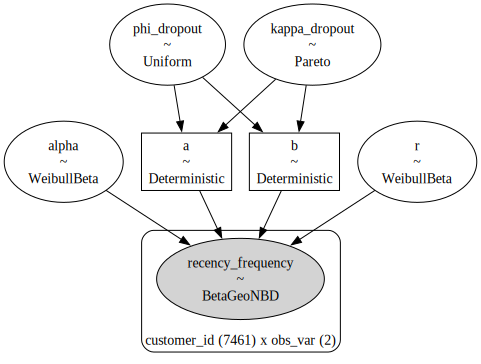

In [24]:
model.graphviz()

In [77]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
}

# Rebuilding the model with updated prior configurations.
model = clv.BetaGeoModel(
    data = data_bg,
    model_config = model_config,
)
model.build_model()

sample_kwargs = {
    "draws": 2_000,
    "chains": 4,
    "target_accept": 0.9,
    "random_seed": 42,
}
idata_mcmc = model.fit(**sample_kwargs)
idata_mcmc

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, a, b, r]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 80 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

In [79]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.317,0.087,4.153,4.479,0.001,0.001,4236.0,4299.0,1.0
a,0.099,0.003,0.093,0.105,0.000,0.000,4698.0,4417.0,1.0
b,3.668,0.294,3.126,4.224,0.004,0.003,4672.0,4953.0,1.0
r,0.709,0.010,0.691,0.729,0.000,0.000,4352.0,4386.0,1.0


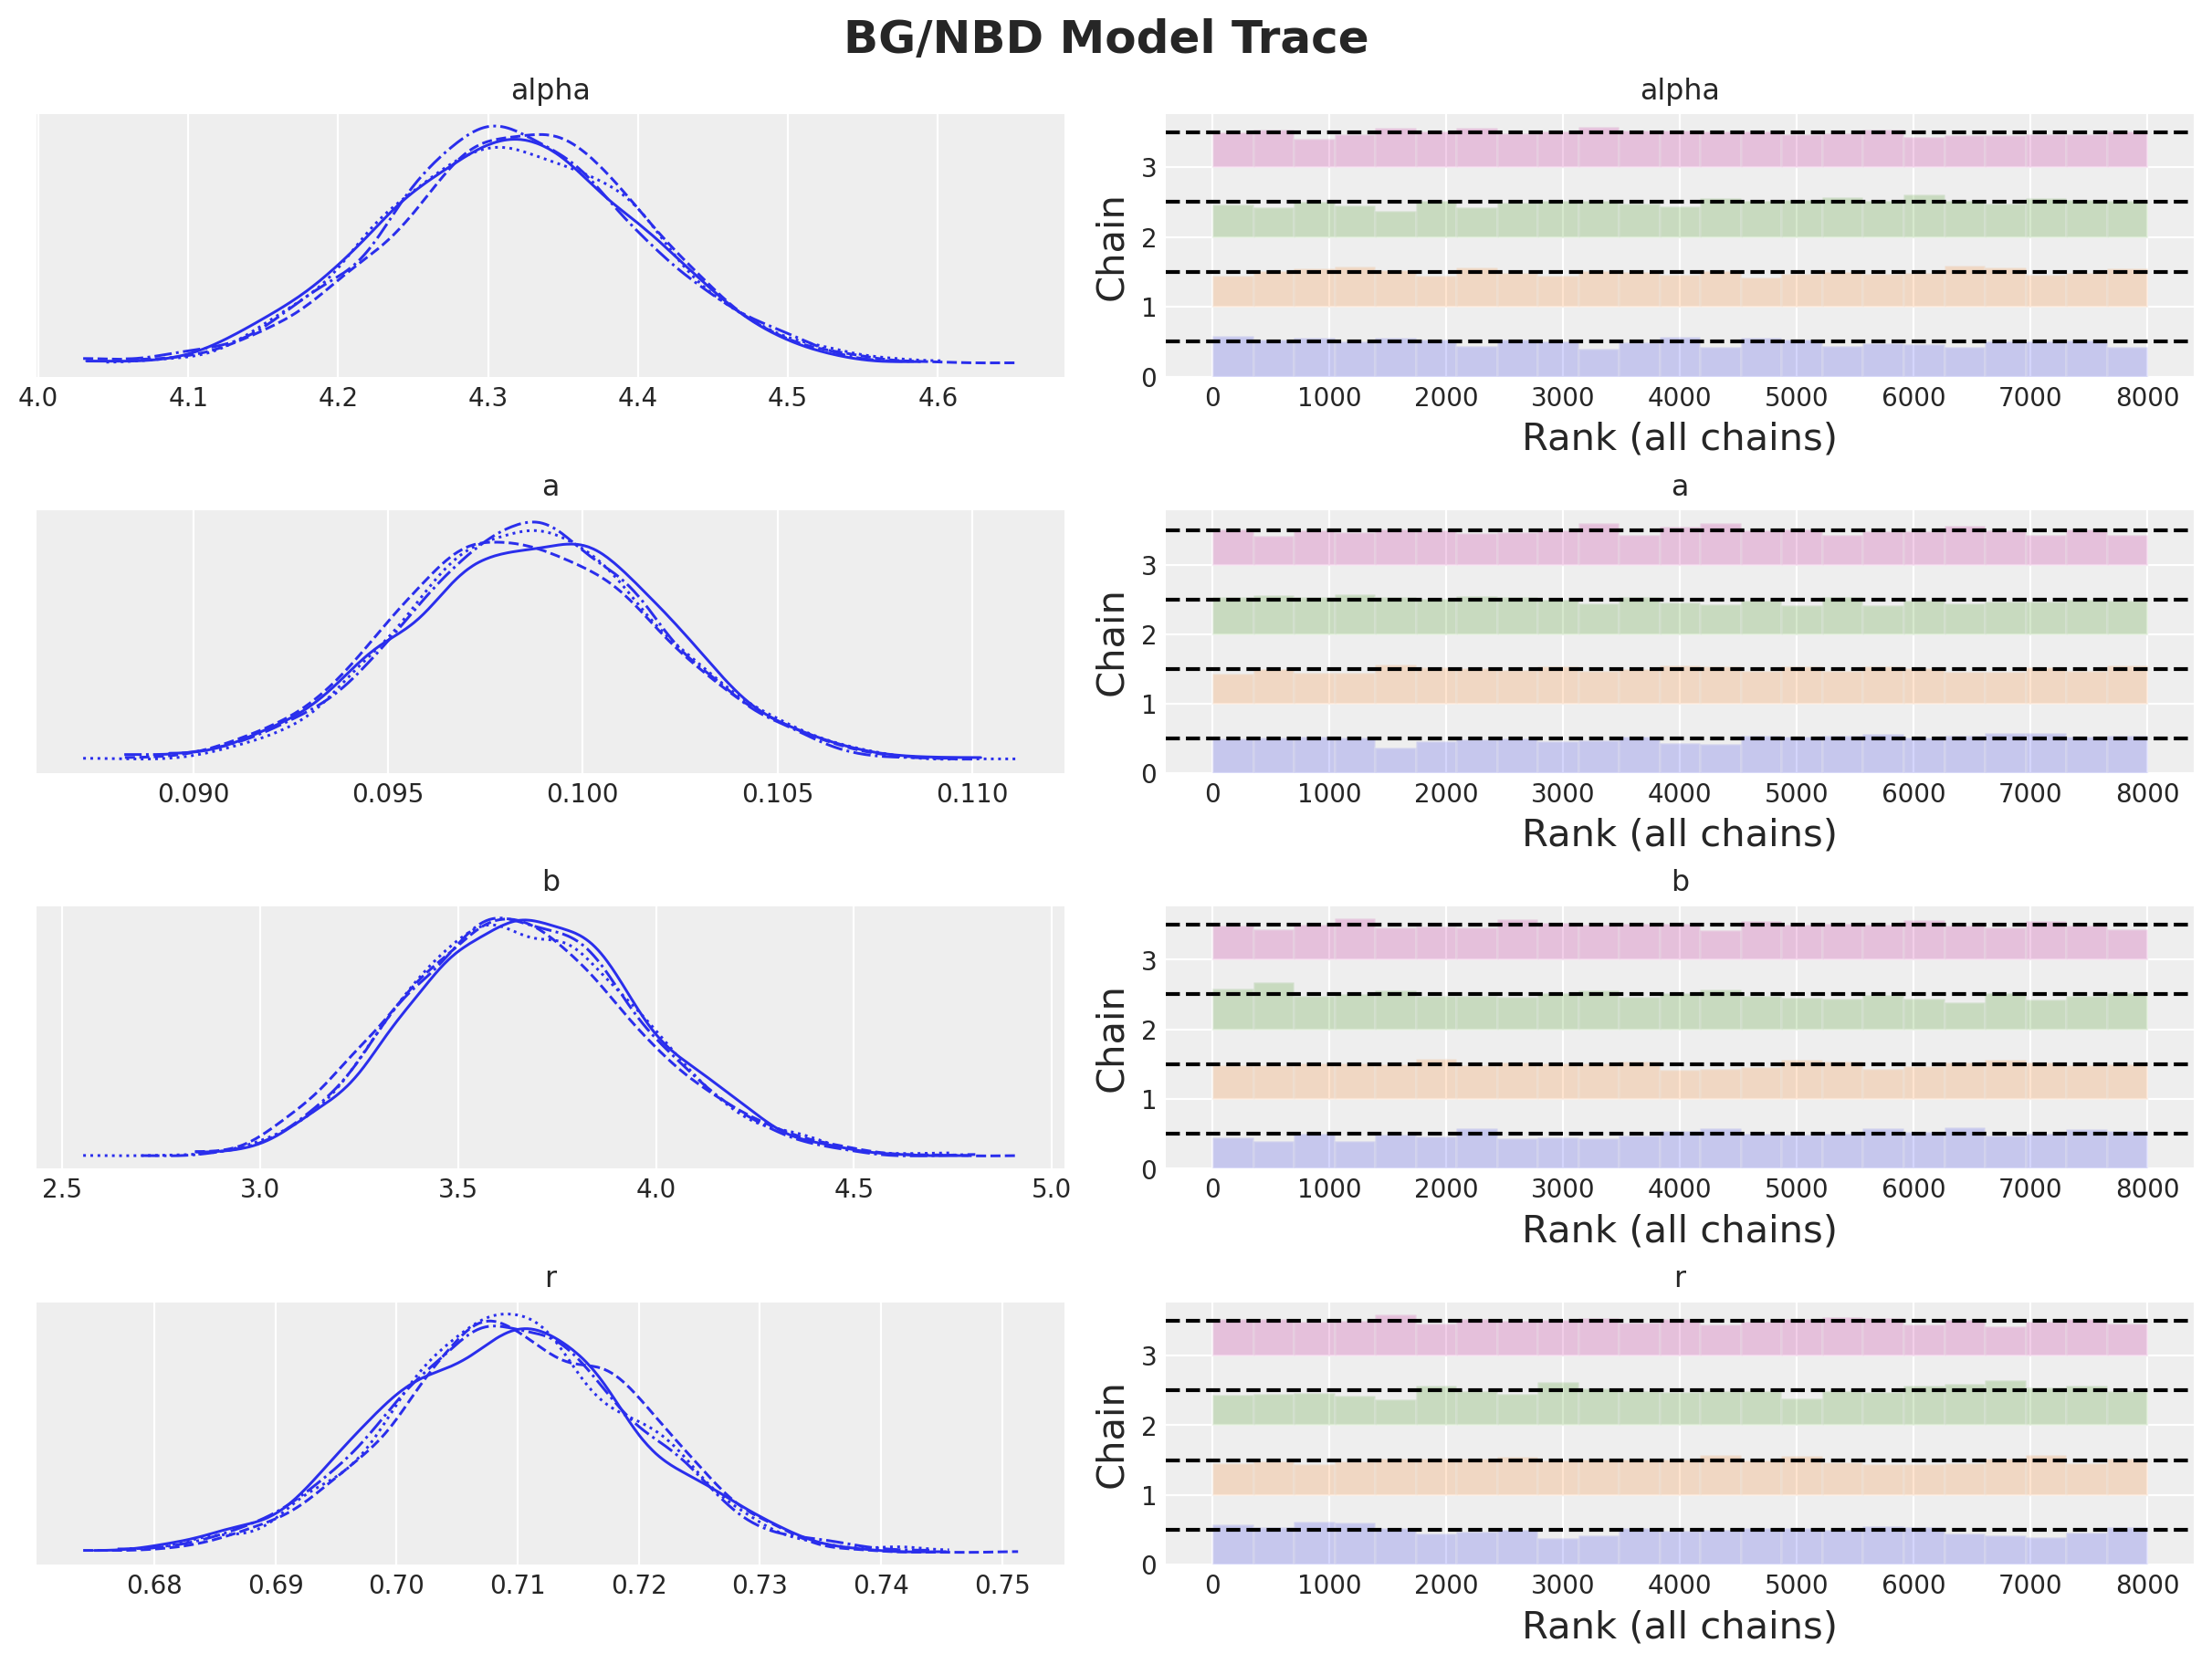

In [80]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("BG/NBD Model Trace", fontsize=18, fontweight="bold");

In [81]:
model_map = clv.BetaGeoModel(data=data_bg)
idata_map = model_map.fit(method="map")

Output()

In [82]:
idata_map
map_summary = model_map.fit_summary()

map_summary

alpha            4.317
phi_dropout      0.027
kappa_dropout    3.678
r                0.709
a                0.098
b                3.580
Name: value, dtype: float64

In [83]:
bgf = BetaGeoFitter()
bgf.fit(
    frequency=data_bg["frequency"].values,
    recency=data_bg["recency"].values,
    T=data_bg["T"].values,
)

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.709177,0.010114,0.689353,0.729001
alpha,4.315056,0.084859,4.148732,4.481380
a,0.098420,0.003304,0.091944,0.104897
b,3.629627,0.293732,3.053913,4.205341


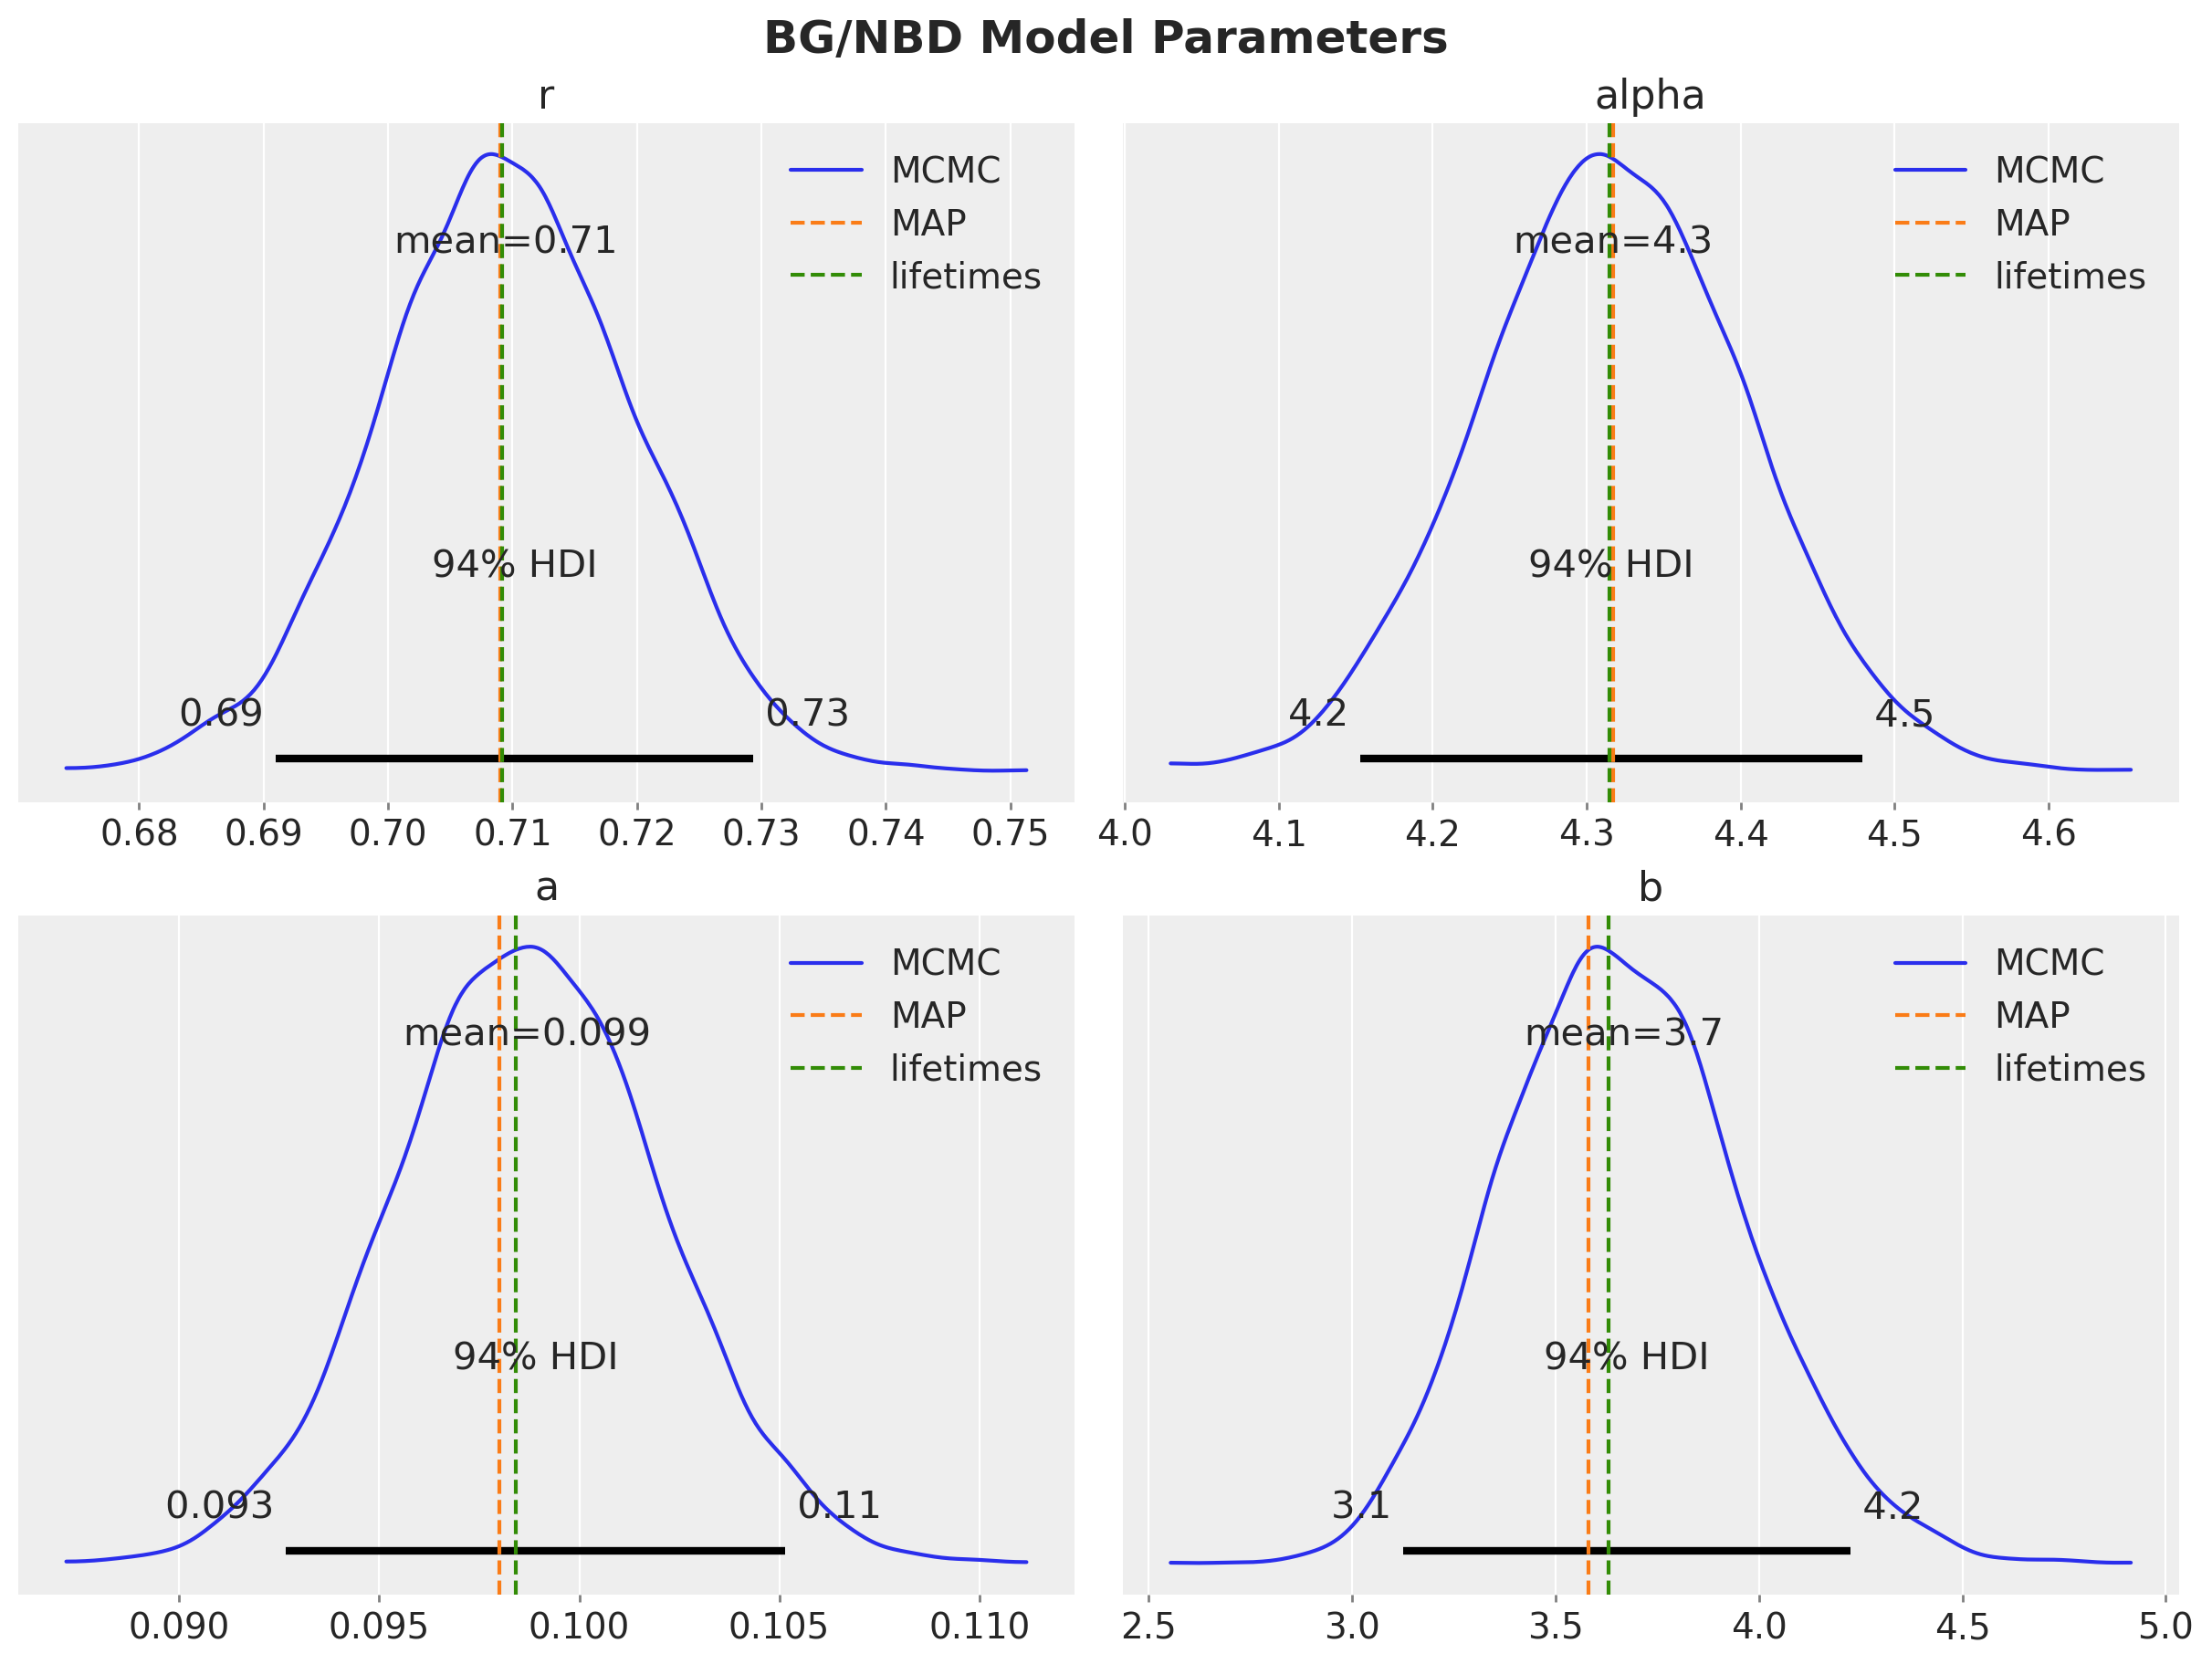

In [84]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "a", "b"]):
    ax = axes[i]
    az.plot_posterior(
        model.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="MCMC",
    )
    ax.axvline(x=map_summary[var_name], color="C1", linestyle="--", label="MAP")
    ax.axvline(
        x=bgf.summary["coef"][var_name], color="C2", linestyle="--", label="lifetimes"
    )
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("BG/NBD Model Parameters", fontsize=18, fontweight="bold");

Sampling: [a, alpha, b, r, recency_frequency]


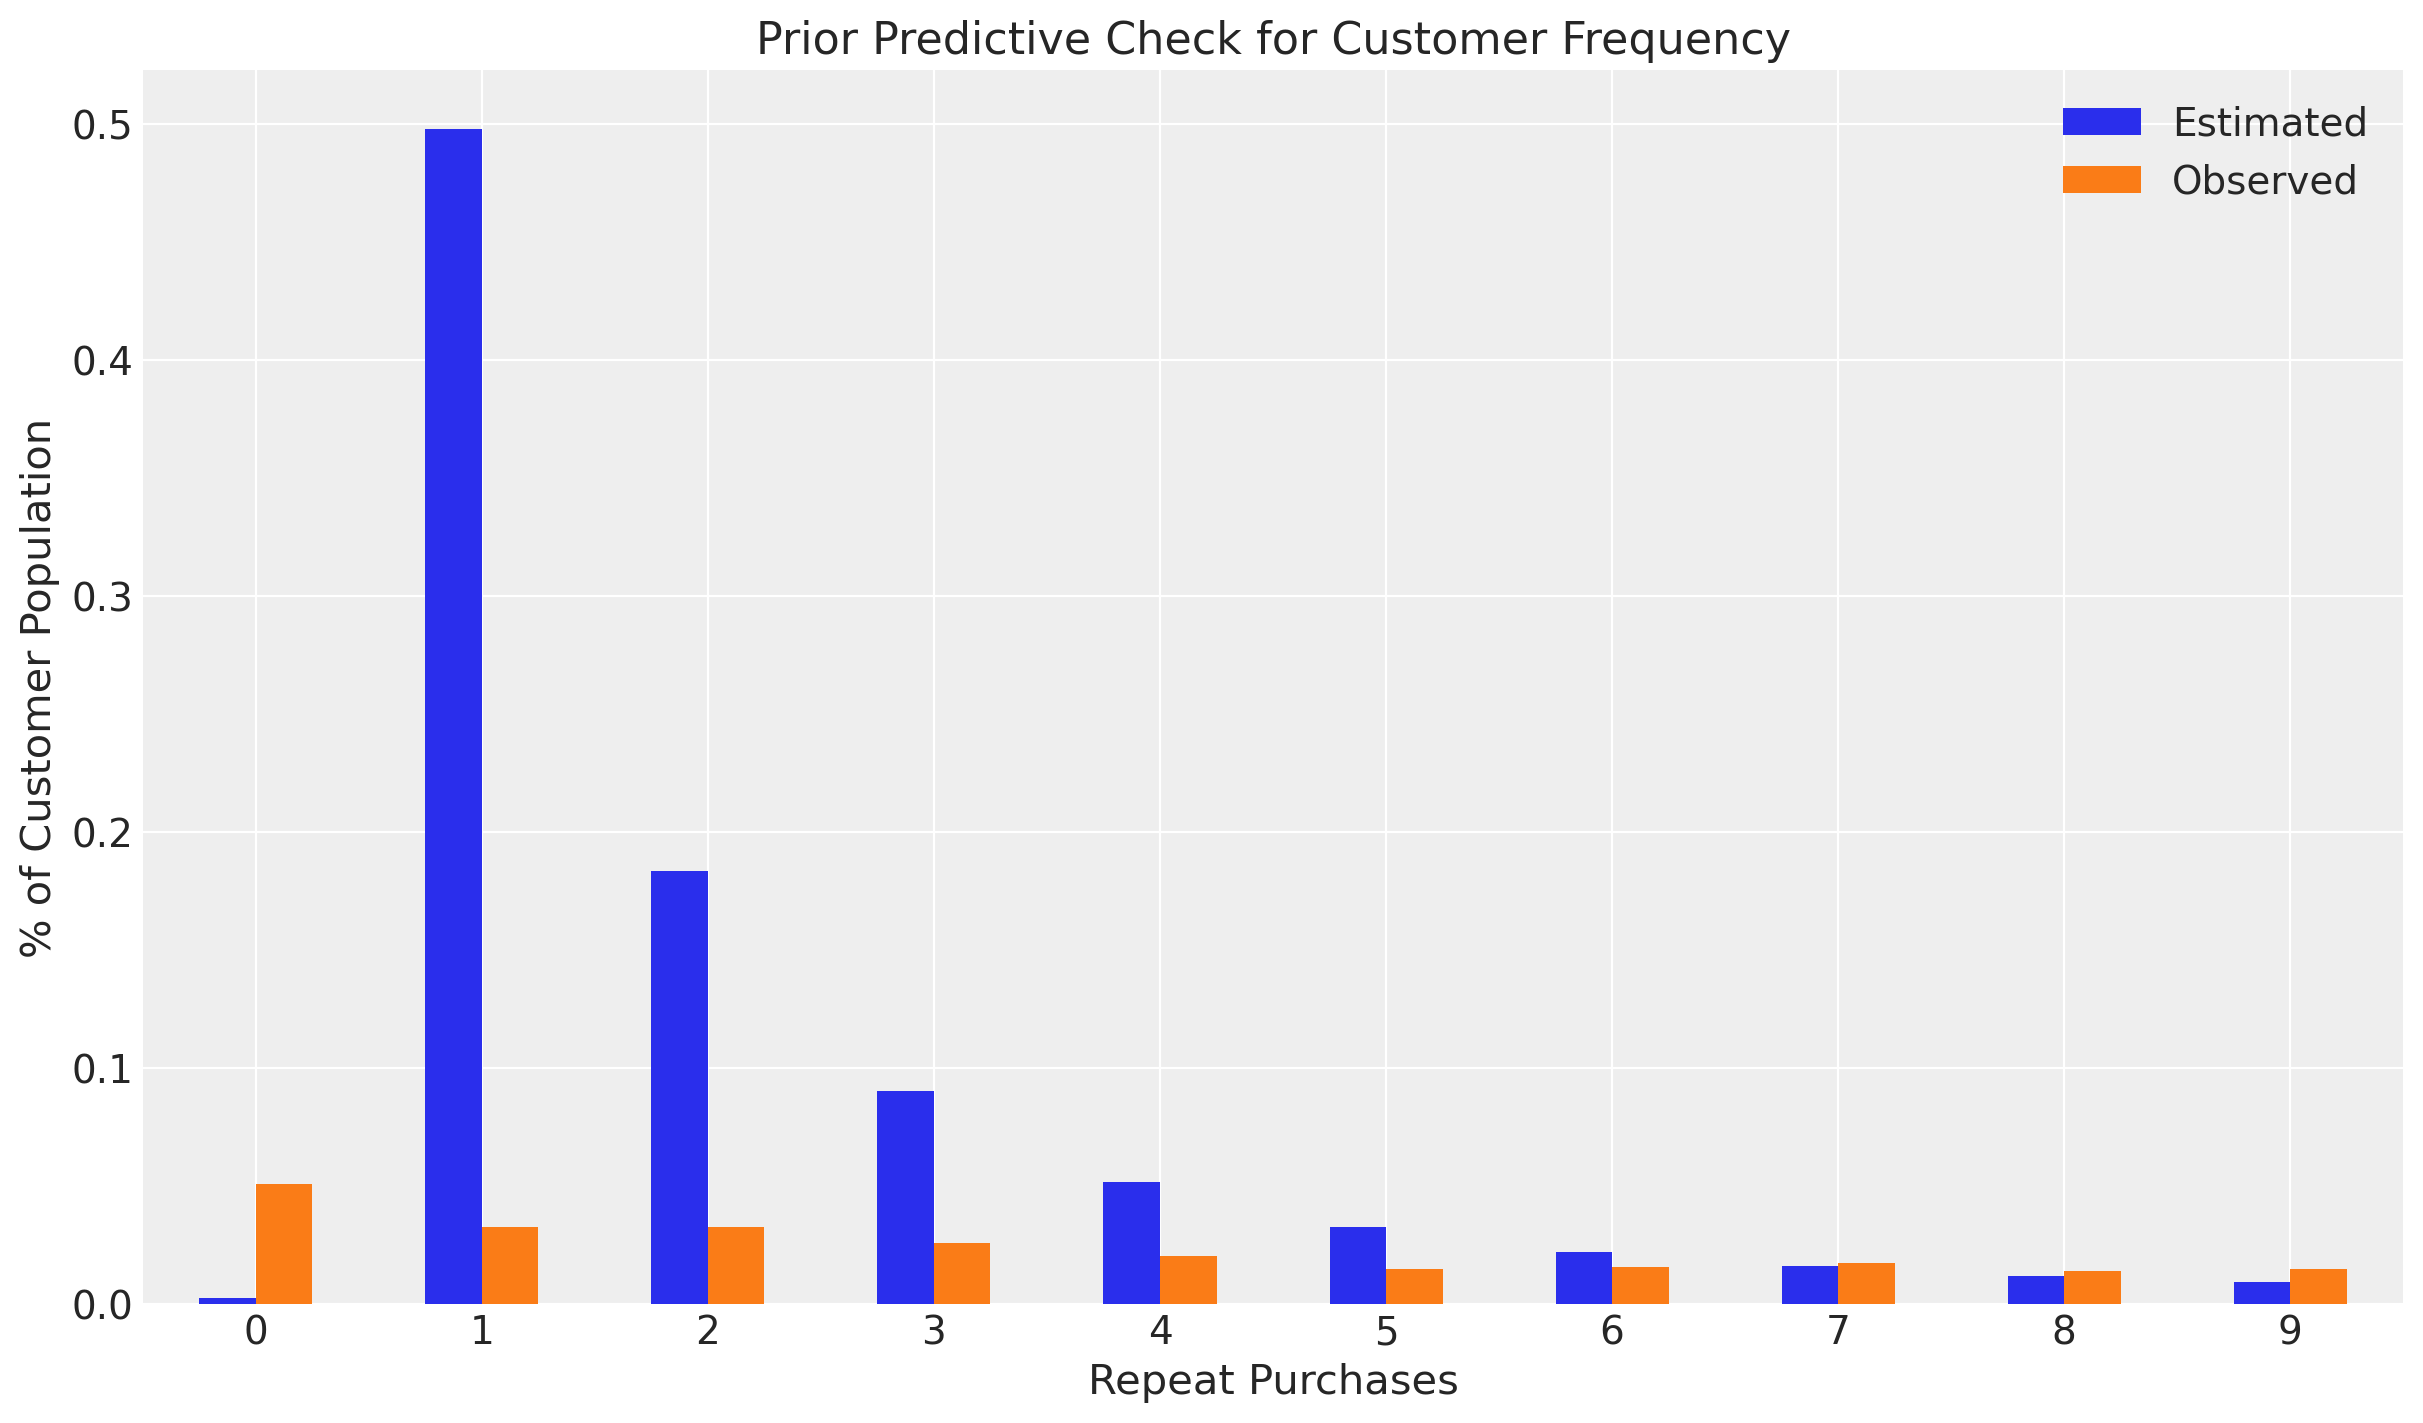

In [33]:
clv.plot_expected_purchases_ppc(model, ppc="prior");

Sampling: [recency_frequency]


Output()

KeyboardInterrupt: 

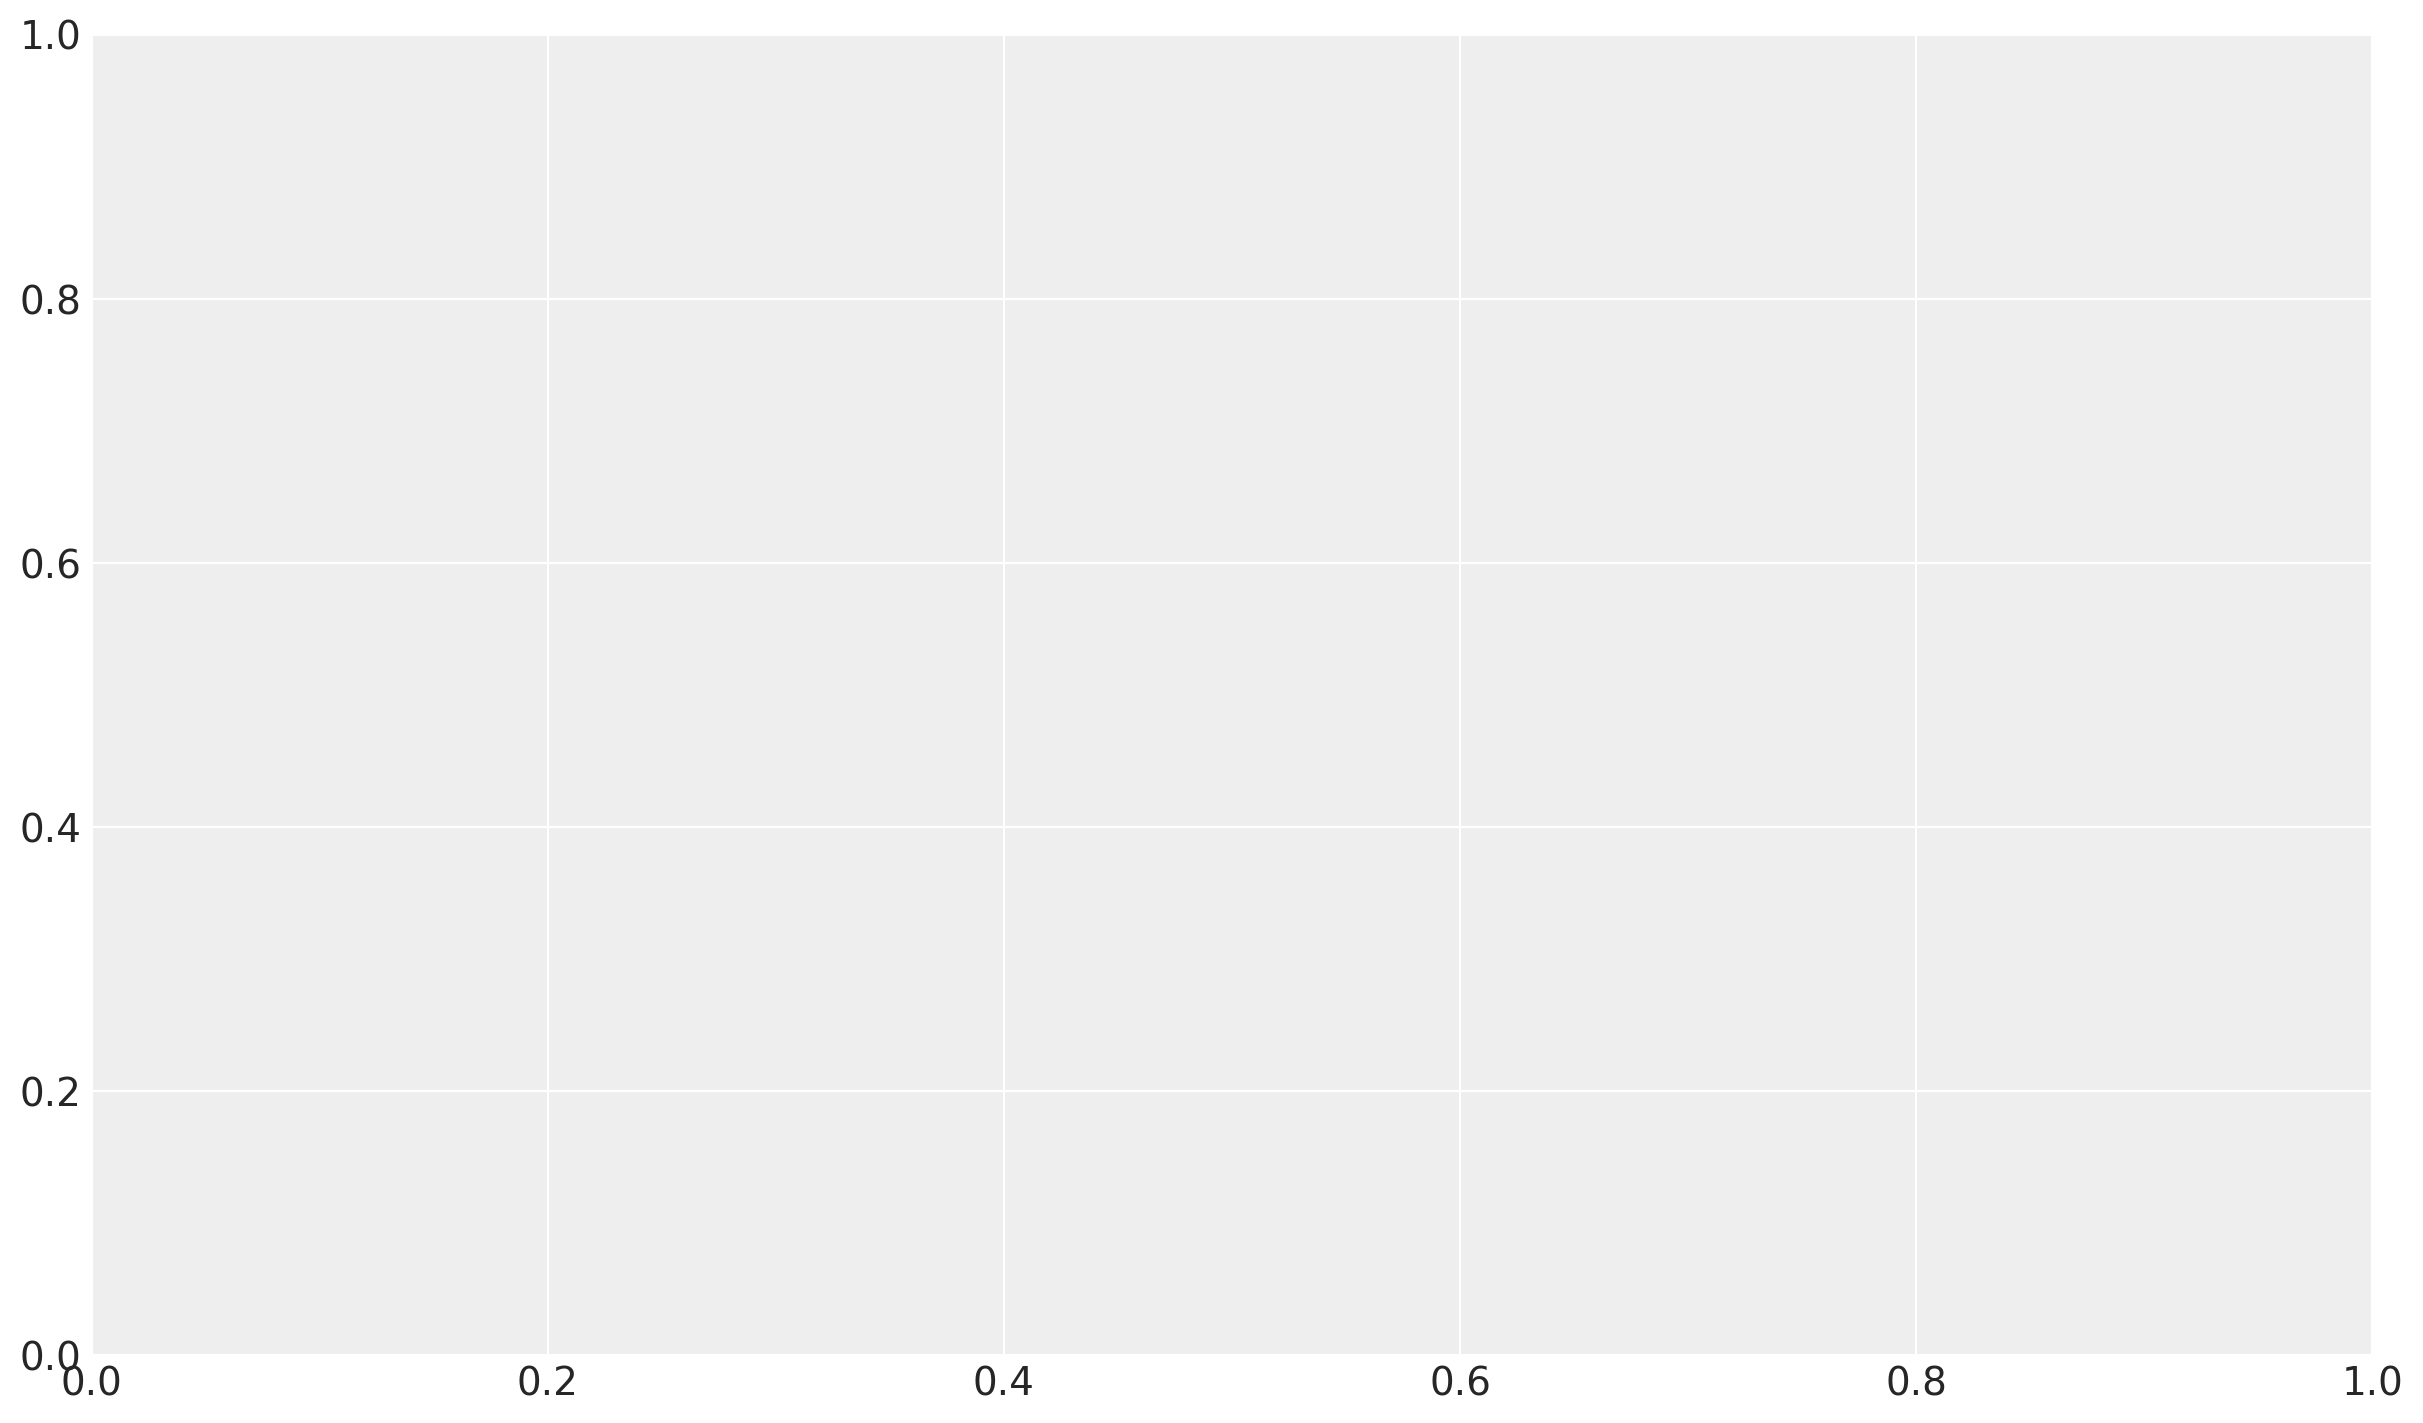

In [34]:
clv.plot_expected_purchases_ppc(model, ppc="posterior");

In [88]:
example_customer_ids = ['1364781544796422146', '33485', '35036', '33475', '4987', '5039']

data_small = data_summary_rfm.query("customer_id.isin(@example_customer_ids)")

data_small.head(6)

,customer_id,frequency,recency,T,monetary_value
1224,1364781544796422146,1192.0,1376.0,1376.0,1693.431208
7743,33475,945.0,2098.0,2098.0,120.121693
7744,33485,1786.0,2093.0,2093.0,402.525196
7826,35036,1060.0,1344.0,2059.0,427.688679
8091,4987,884.0,1683.0,1909.0,74.802036
8093,5039,4.0,630.0,1243.0,30.000000


In [89]:
steps = 90

expected_num_purchases_steps = xr.concat(
    objs=[
        model.expected_purchases(
            data=data_small,
            future_t=t,
        )
        for t in progress_bar(range(steps))
    ],
    dim="t",
).transpose(..., "t")

### Predicting purchase behavior of a new customer

We can use the fitted model to predict the number of purchases for a fresh new customer.

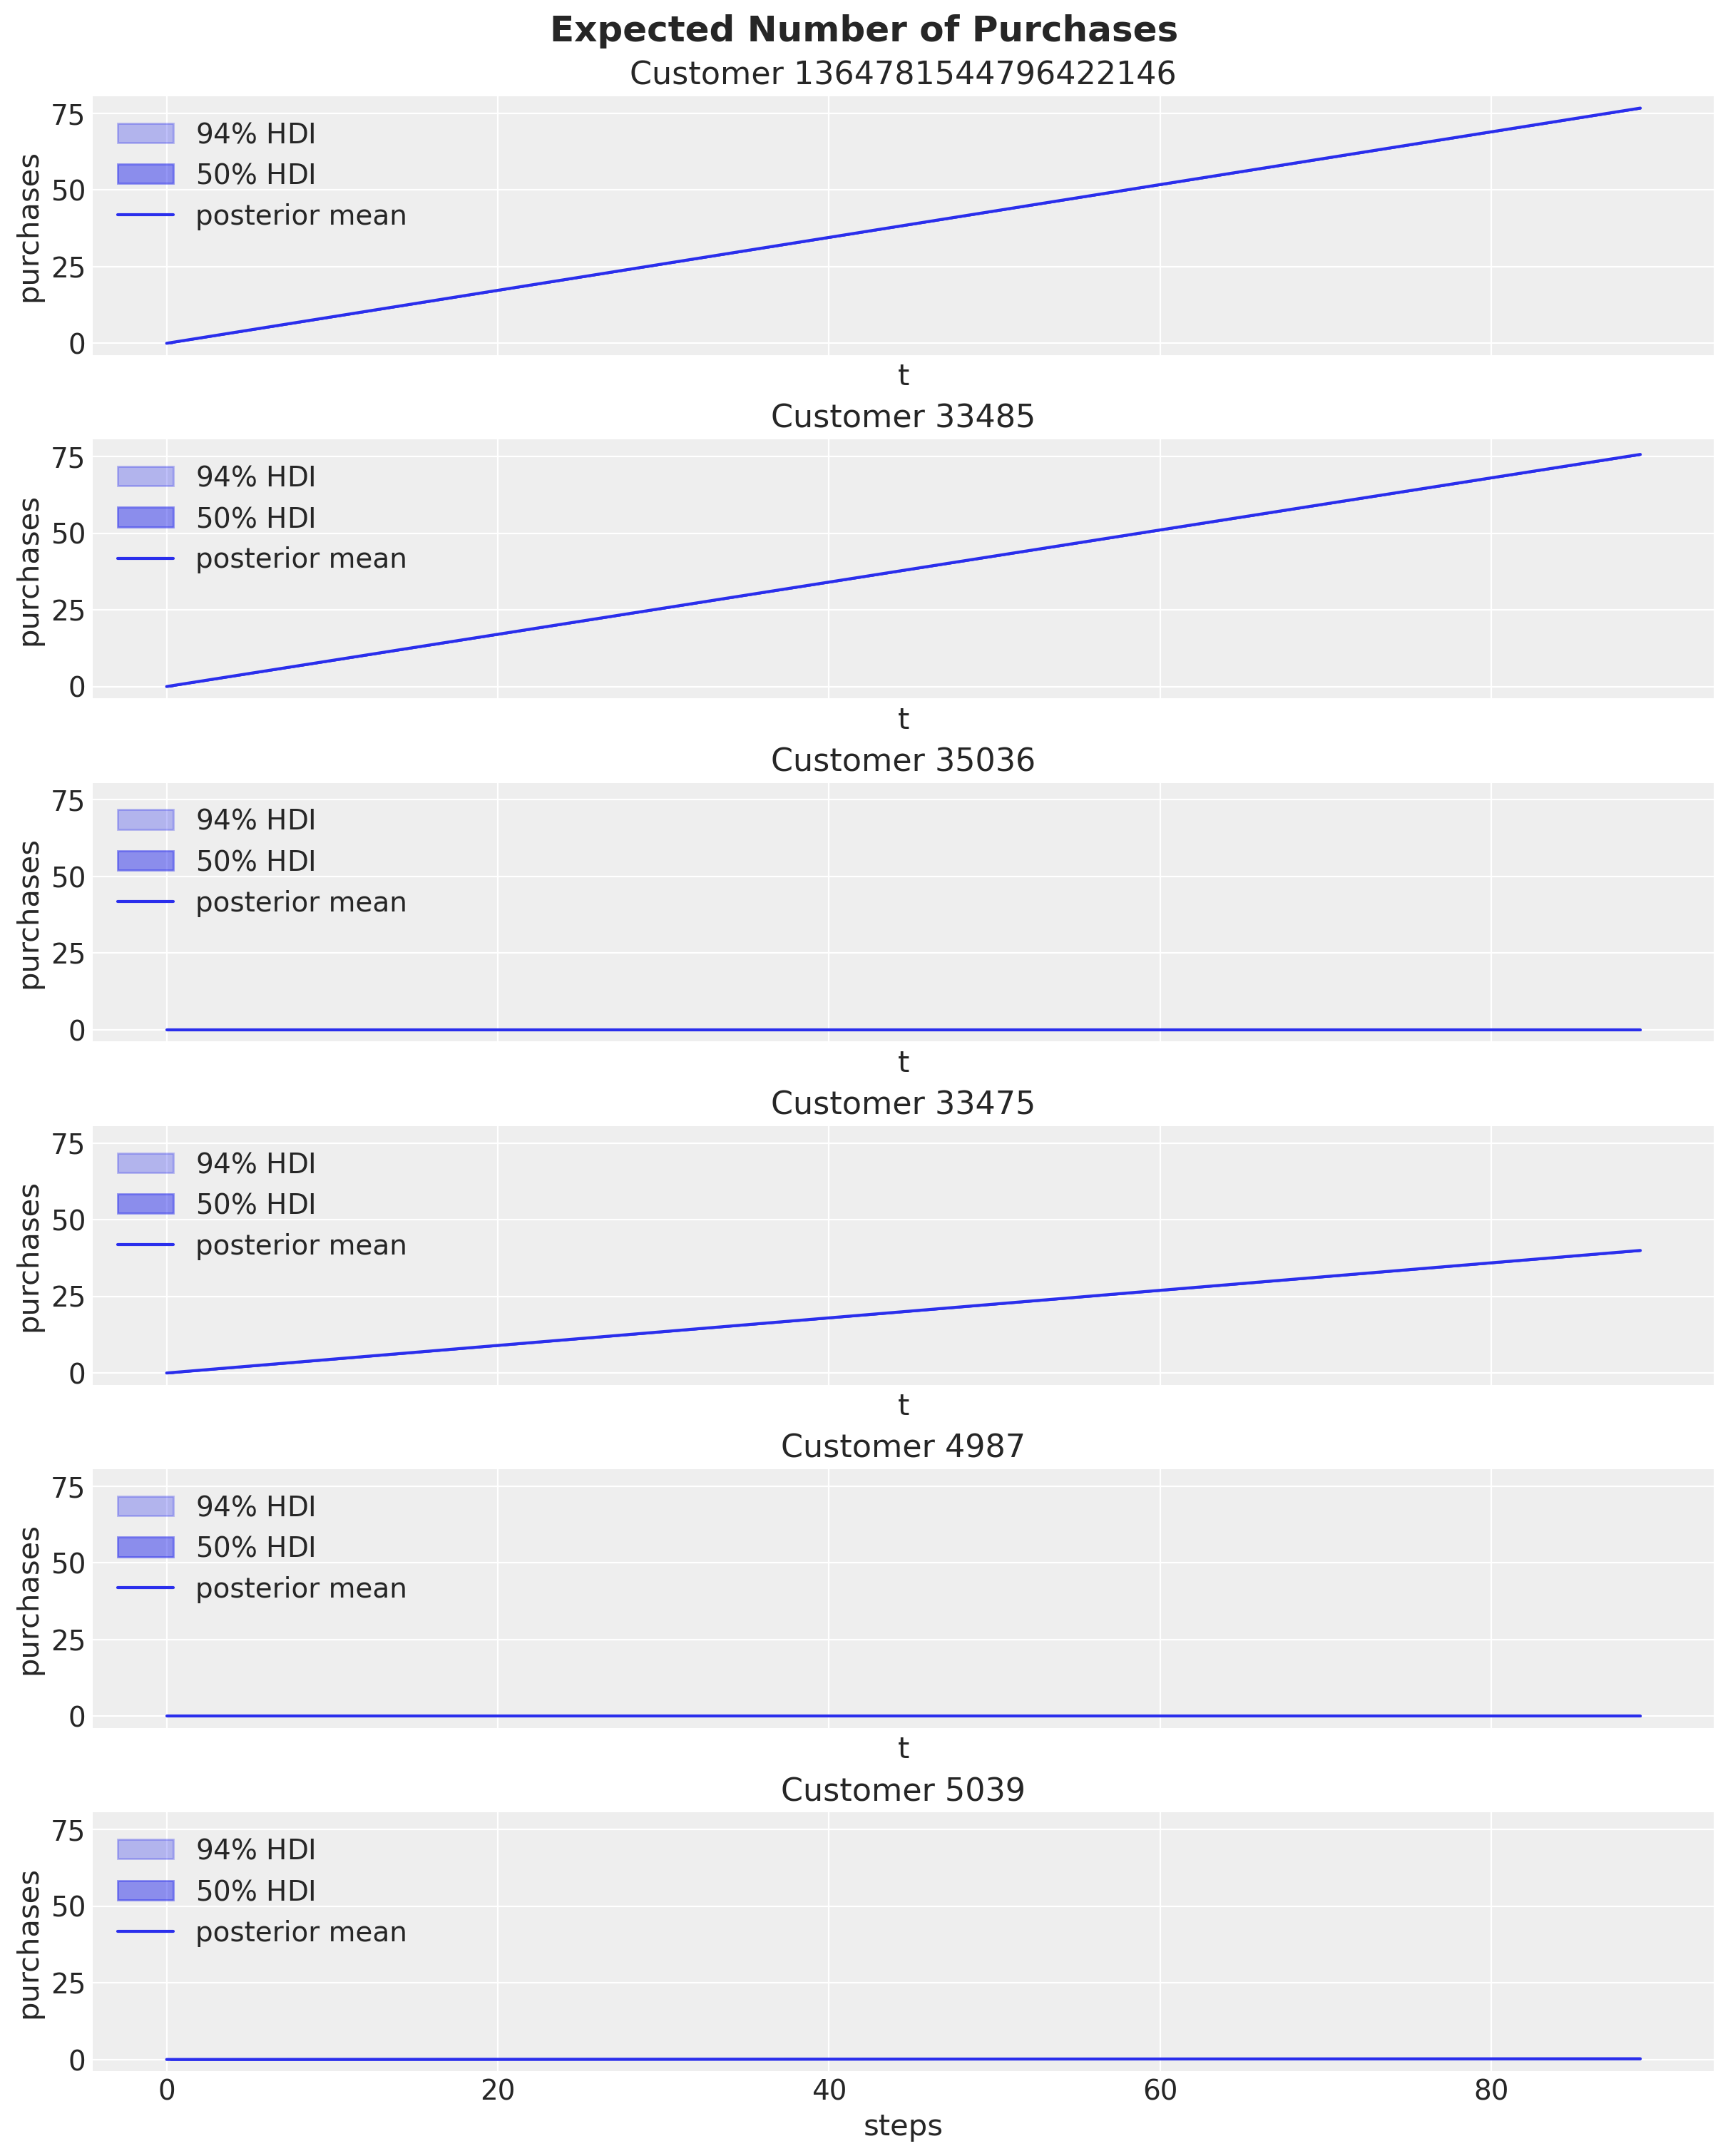

In [90]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_num_purchases_steps = expected_num_purchases_steps.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(steps),
        customer_expected_num_purchases_steps,
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_num_purchases_steps,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_num_purchases_steps.mean(dim=("chain", "draw")),
        color="C0",
        label="posterior mean",
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Customer {customer_id}", xlabel="t", ylabel="purchases")

axes[-1].set(xlabel="steps")
plt.gcf().suptitle("Expected Number of Purchases", fontsize=18, fontweight="bold");

In [91]:
steps = 90

future_alive_all = []

for t in progress_bar(range(steps)):
    future_data = data_small.copy()
    future_data["T"] = future_data["T"] + t
    future_alive = model.expected_probability_alive(data=future_data)
    future_alive_all.append(future_alive)

expected_probability_alive_steps = xr.concat(
    objs=future_alive_all,
    dim="t",
).transpose(..., "t")

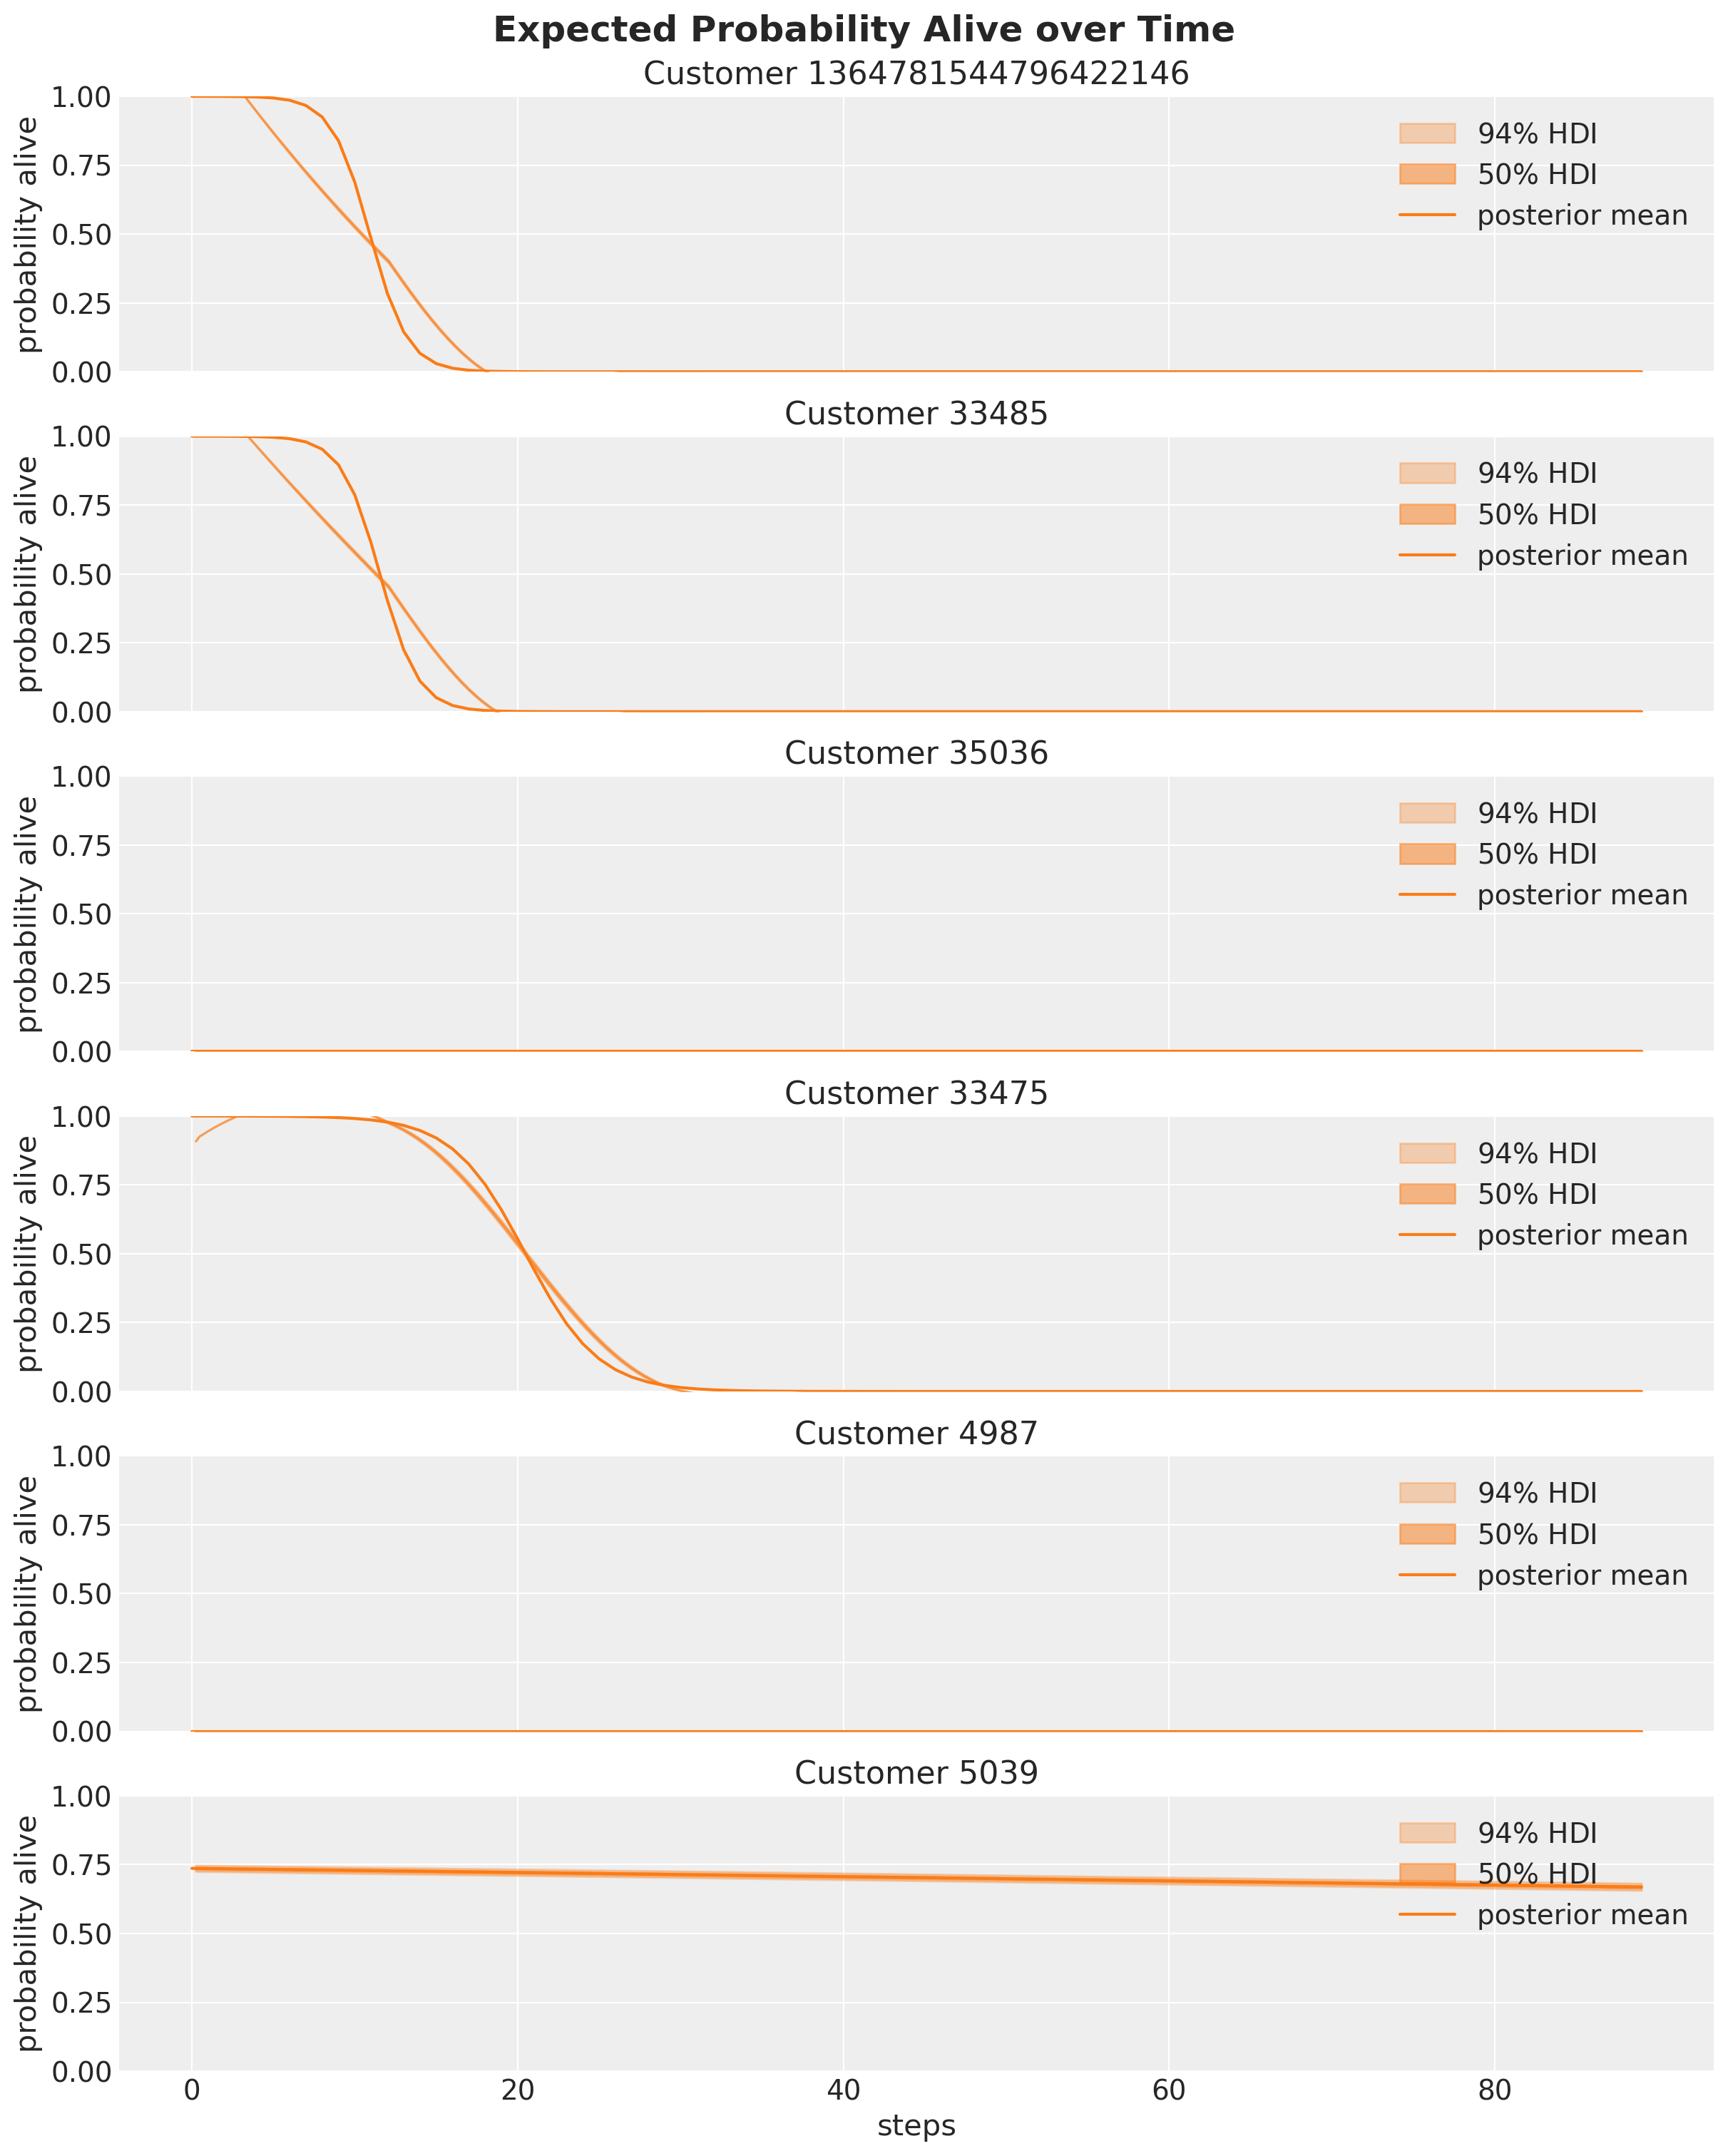

In [92]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_probability_alive_steps = expected_probability_alive_steps.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.5,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_probability_alive_steps.mean(dim=("chain", "draw")),
        color="C1",
        label="posterior mean",
    )
    ax.legend(loc="upper right")
    ax.set(title=f"Customer {customer_id}", ylabel="probability alive", ylim=(0, 1))

axes[-1].set(xlabel="steps")
plt.gcf().suptitle(
    "Expected Probability Alive over Time", fontsize=18, fontweight="bold"
);

In [93]:
steps = 30
expected_probability_zero_purchases = xr.concat(
    objs=[
        model.expected_probability_no_purchase(
            data=data_small,
            t=t,
        )
        for t in progress_bar(range(steps))
    ],
    dim="t",
).transpose(..., "t")

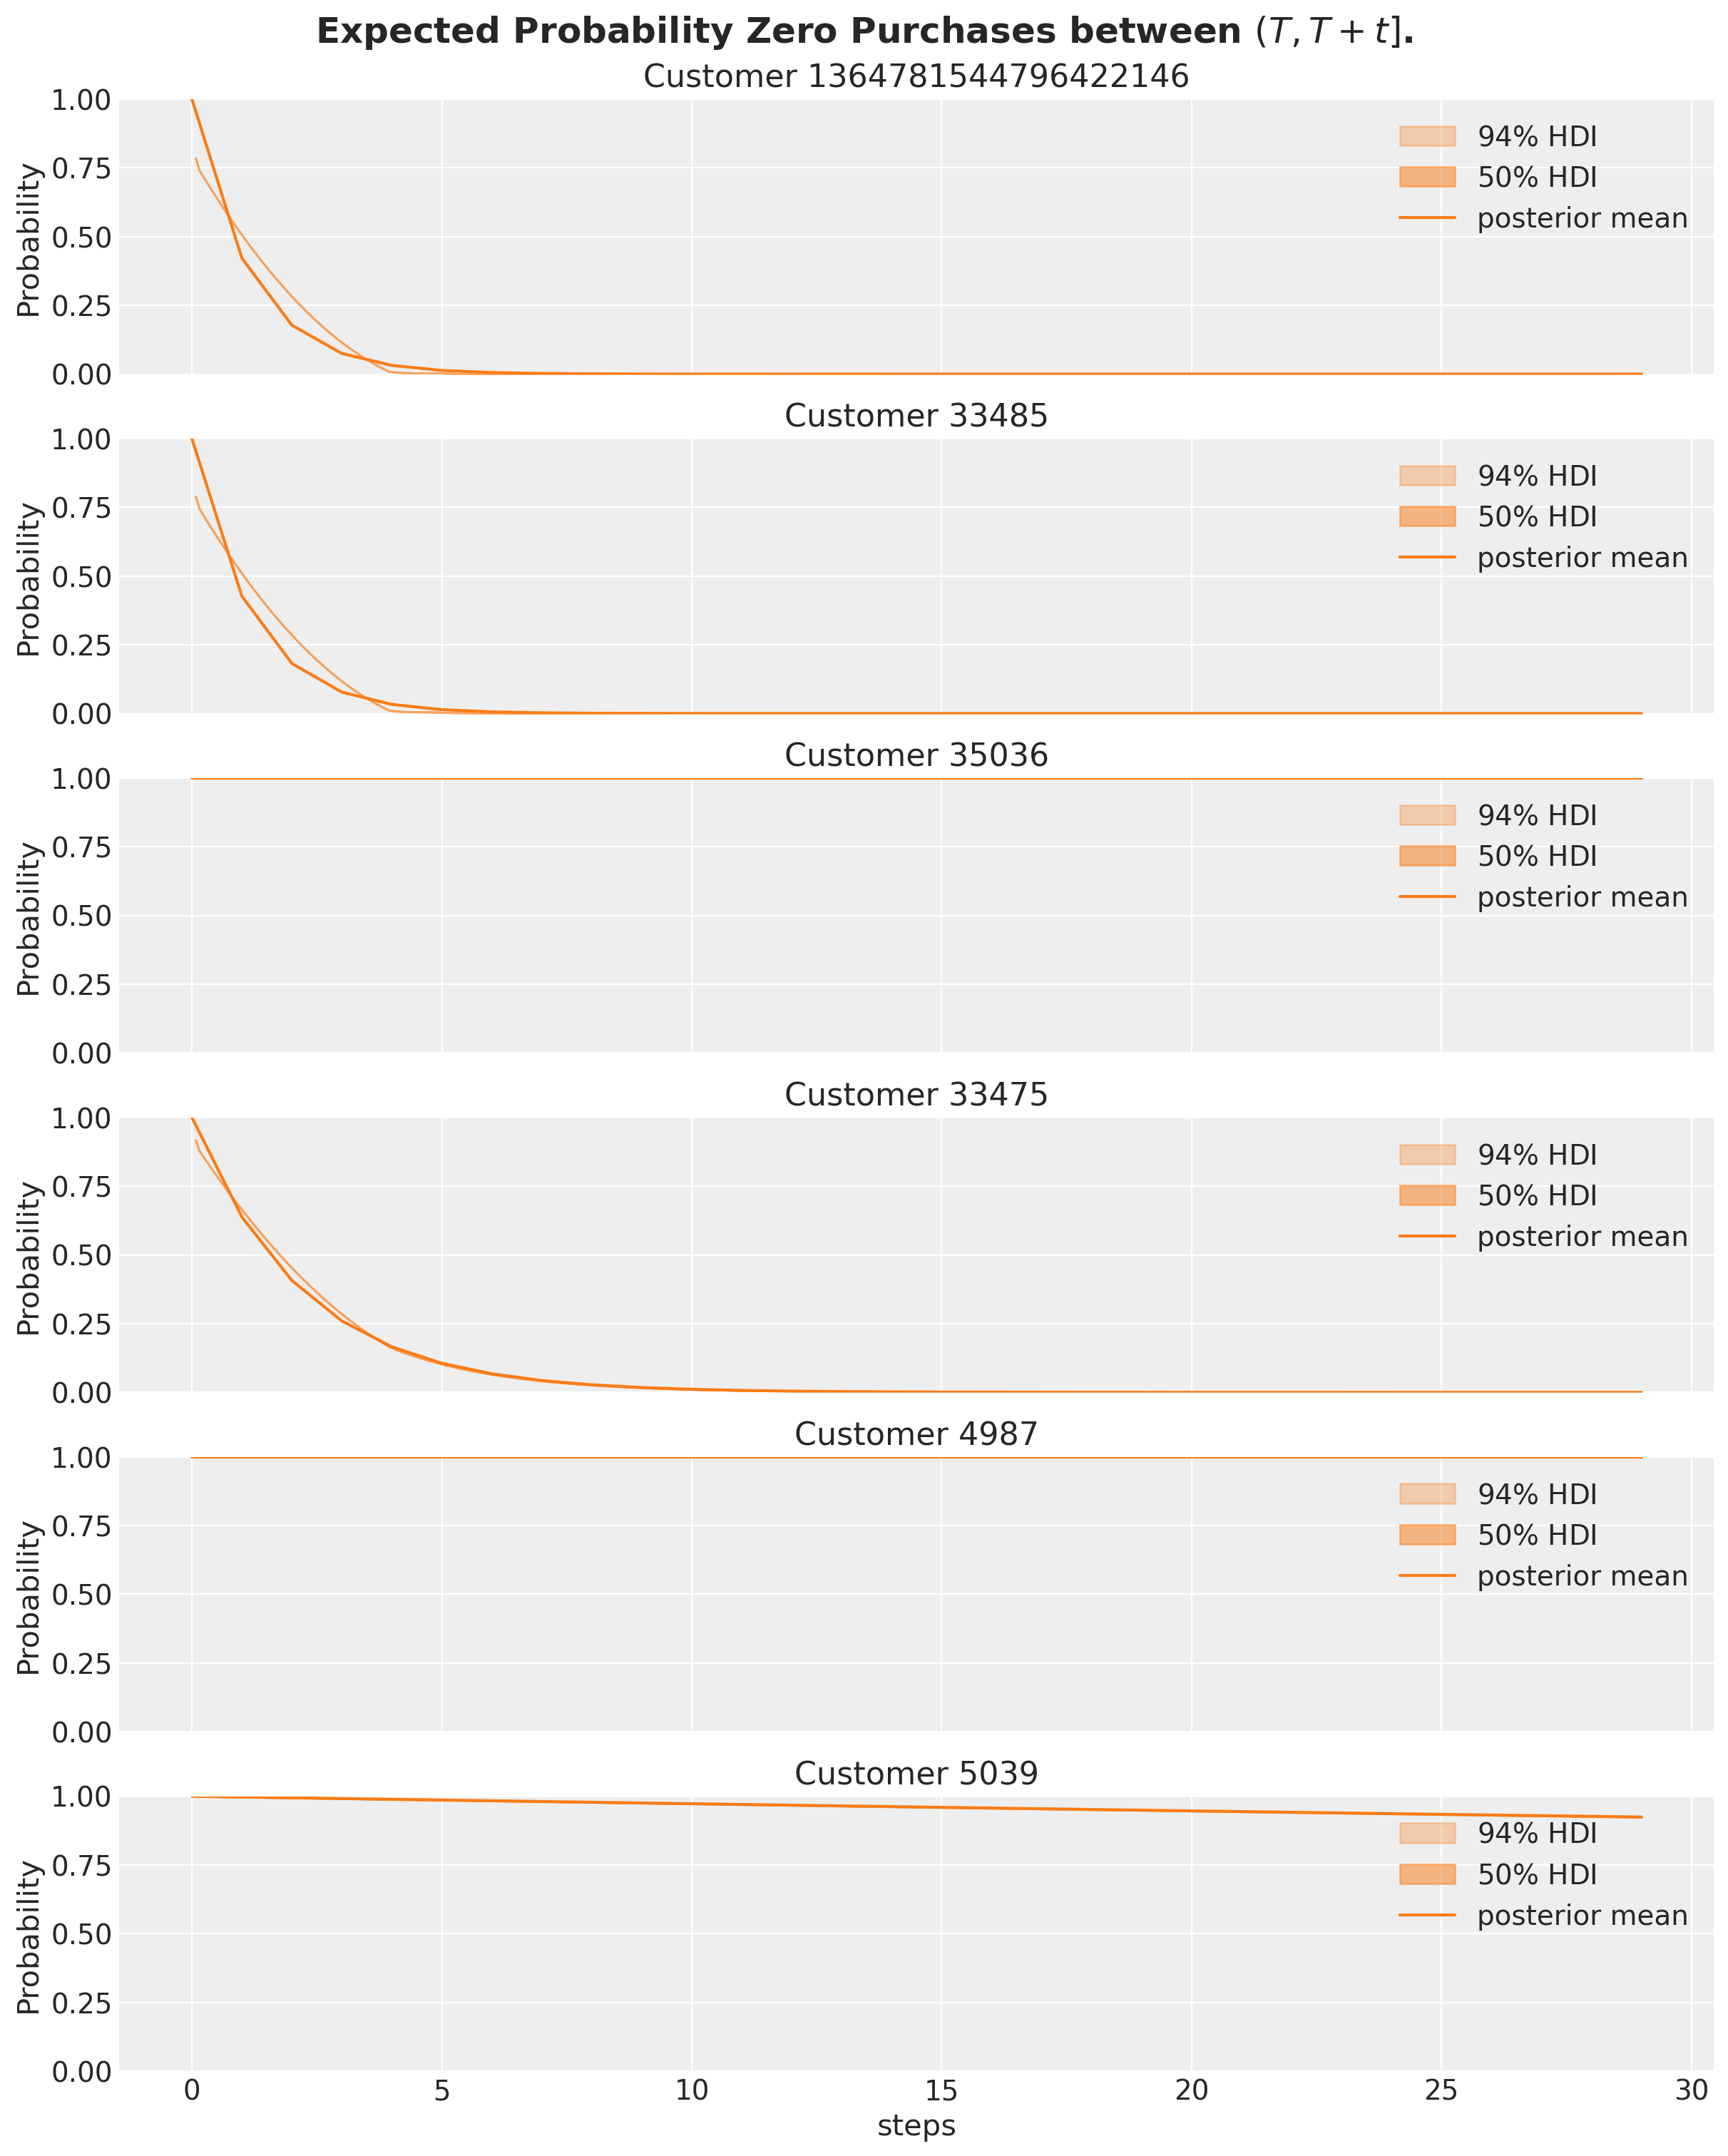

In [94]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_probability_zero_purchases = (
        expected_probability_zero_purchases.sel(customer_id=customer_id)
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_zero_purchases,
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_zero_purchases,
        hdi_prob=0.5,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_probability_zero_purchases.mean(dim=("chain", "draw")),
        color="C1",
        label="posterior mean",
    )
    ax.legend(loc="upper right")
    ax.set(title=f"Customer {customer_id}", ylabel="Probability", ylim=(0, 1))

axes[-1].set(xlabel="steps")
plt.gcf().suptitle(
    "Expected Probability Zero Purchases between $(T, T+t]$.",
    fontsize=18,
    fontweight="bold",
);

# Gamma-Gamma Model

In [95]:
data_gg = data_summary_rfm.query("monetary_value > 0")
data_gg[["monetary_value", "frequency"]].corr()

,monetary_value,frequency
monetary_value,1.000000,0.262242
frequency,0.262242,1.000000


In [96]:
ggf = GammaGammaFitter()
ggf.fit(
    data_bg["frequency"].values,
    data_bg["monetary_value"].values,
)

ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.549045,0.102982,1.347200,1.750890
q,2.842198,0.050748,2.742733,2.941663
v,124.417134,9.815287,105.179171,143.655097


In [97]:
avg_profit = ggf.conditional_expected_average_profit(
    data_bg["frequency"], data_bg["monetary_value"]
)
avg_profit.head(10)

0      95.451079
1      59.291464
2      47.569131
3      56.418080
4     251.995254
5     134.524615
6     142.086390
7      41.833363
9     100.068123
10    162.178591
dtype: float64

In [98]:
avg_profit.mean()

np.float64(112.64485005449629)

## PyMarketing Implementing

In [99]:
model = clv.GammaGammaModel(data=data_bg)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [100]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [101]:
idata_map

,,p,q,v
chain,draw,,,
0,0,1.549044,2.842198,124.417264


In [102]:
sampler_kwargs = {
    "draws": 2_000,
    "target_accept": 0.9,
    "chains": 4,
    "random_seed": 42,
}

idata_mcmc = model.fit(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 108 seconds.


In [104]:
idata_mcmc

Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

In [105]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.554,0.102,1.365,1.745,0.002,0.002,1940.0,2514.0,1.0
q,2.843,0.051,2.753,2.944,0.001,0.001,2236.0,2951.0,1.0
v,124.705,9.705,106.231,142.701,0.228,0.146,1803.0,2571.0,1.0


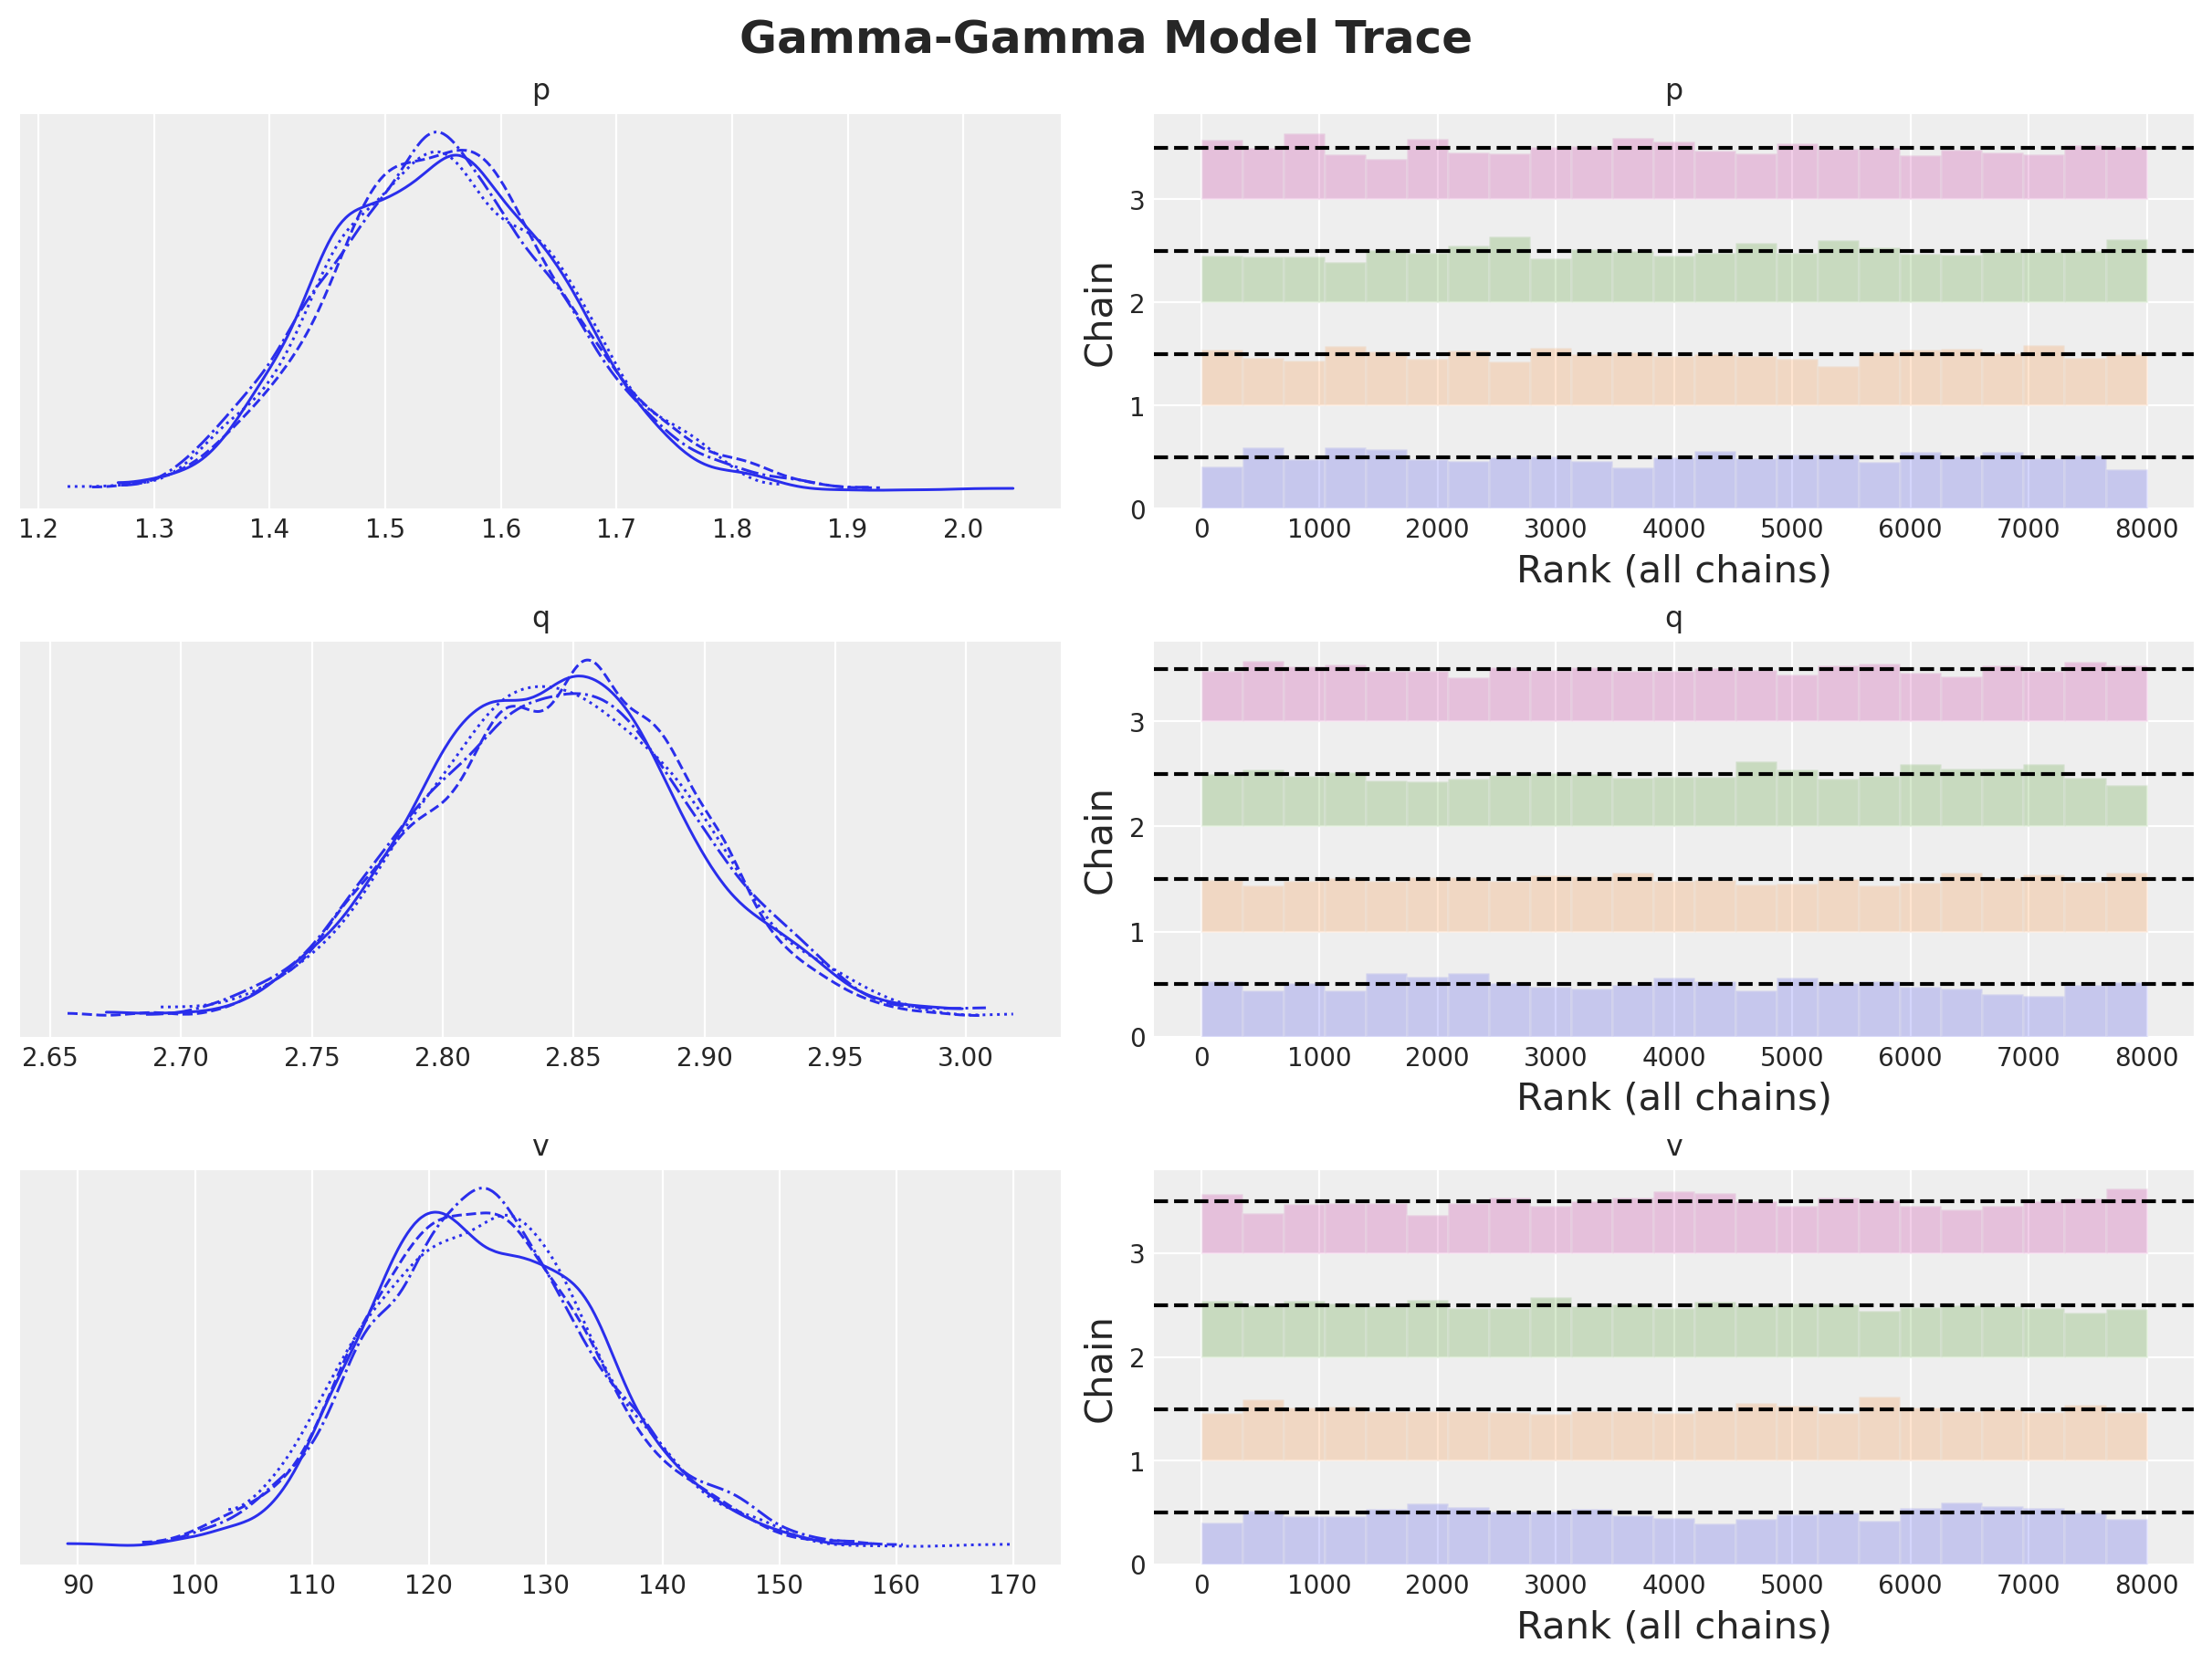

In [106]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma-Gamma Model Trace", fontsize=18, fontweight="bold");

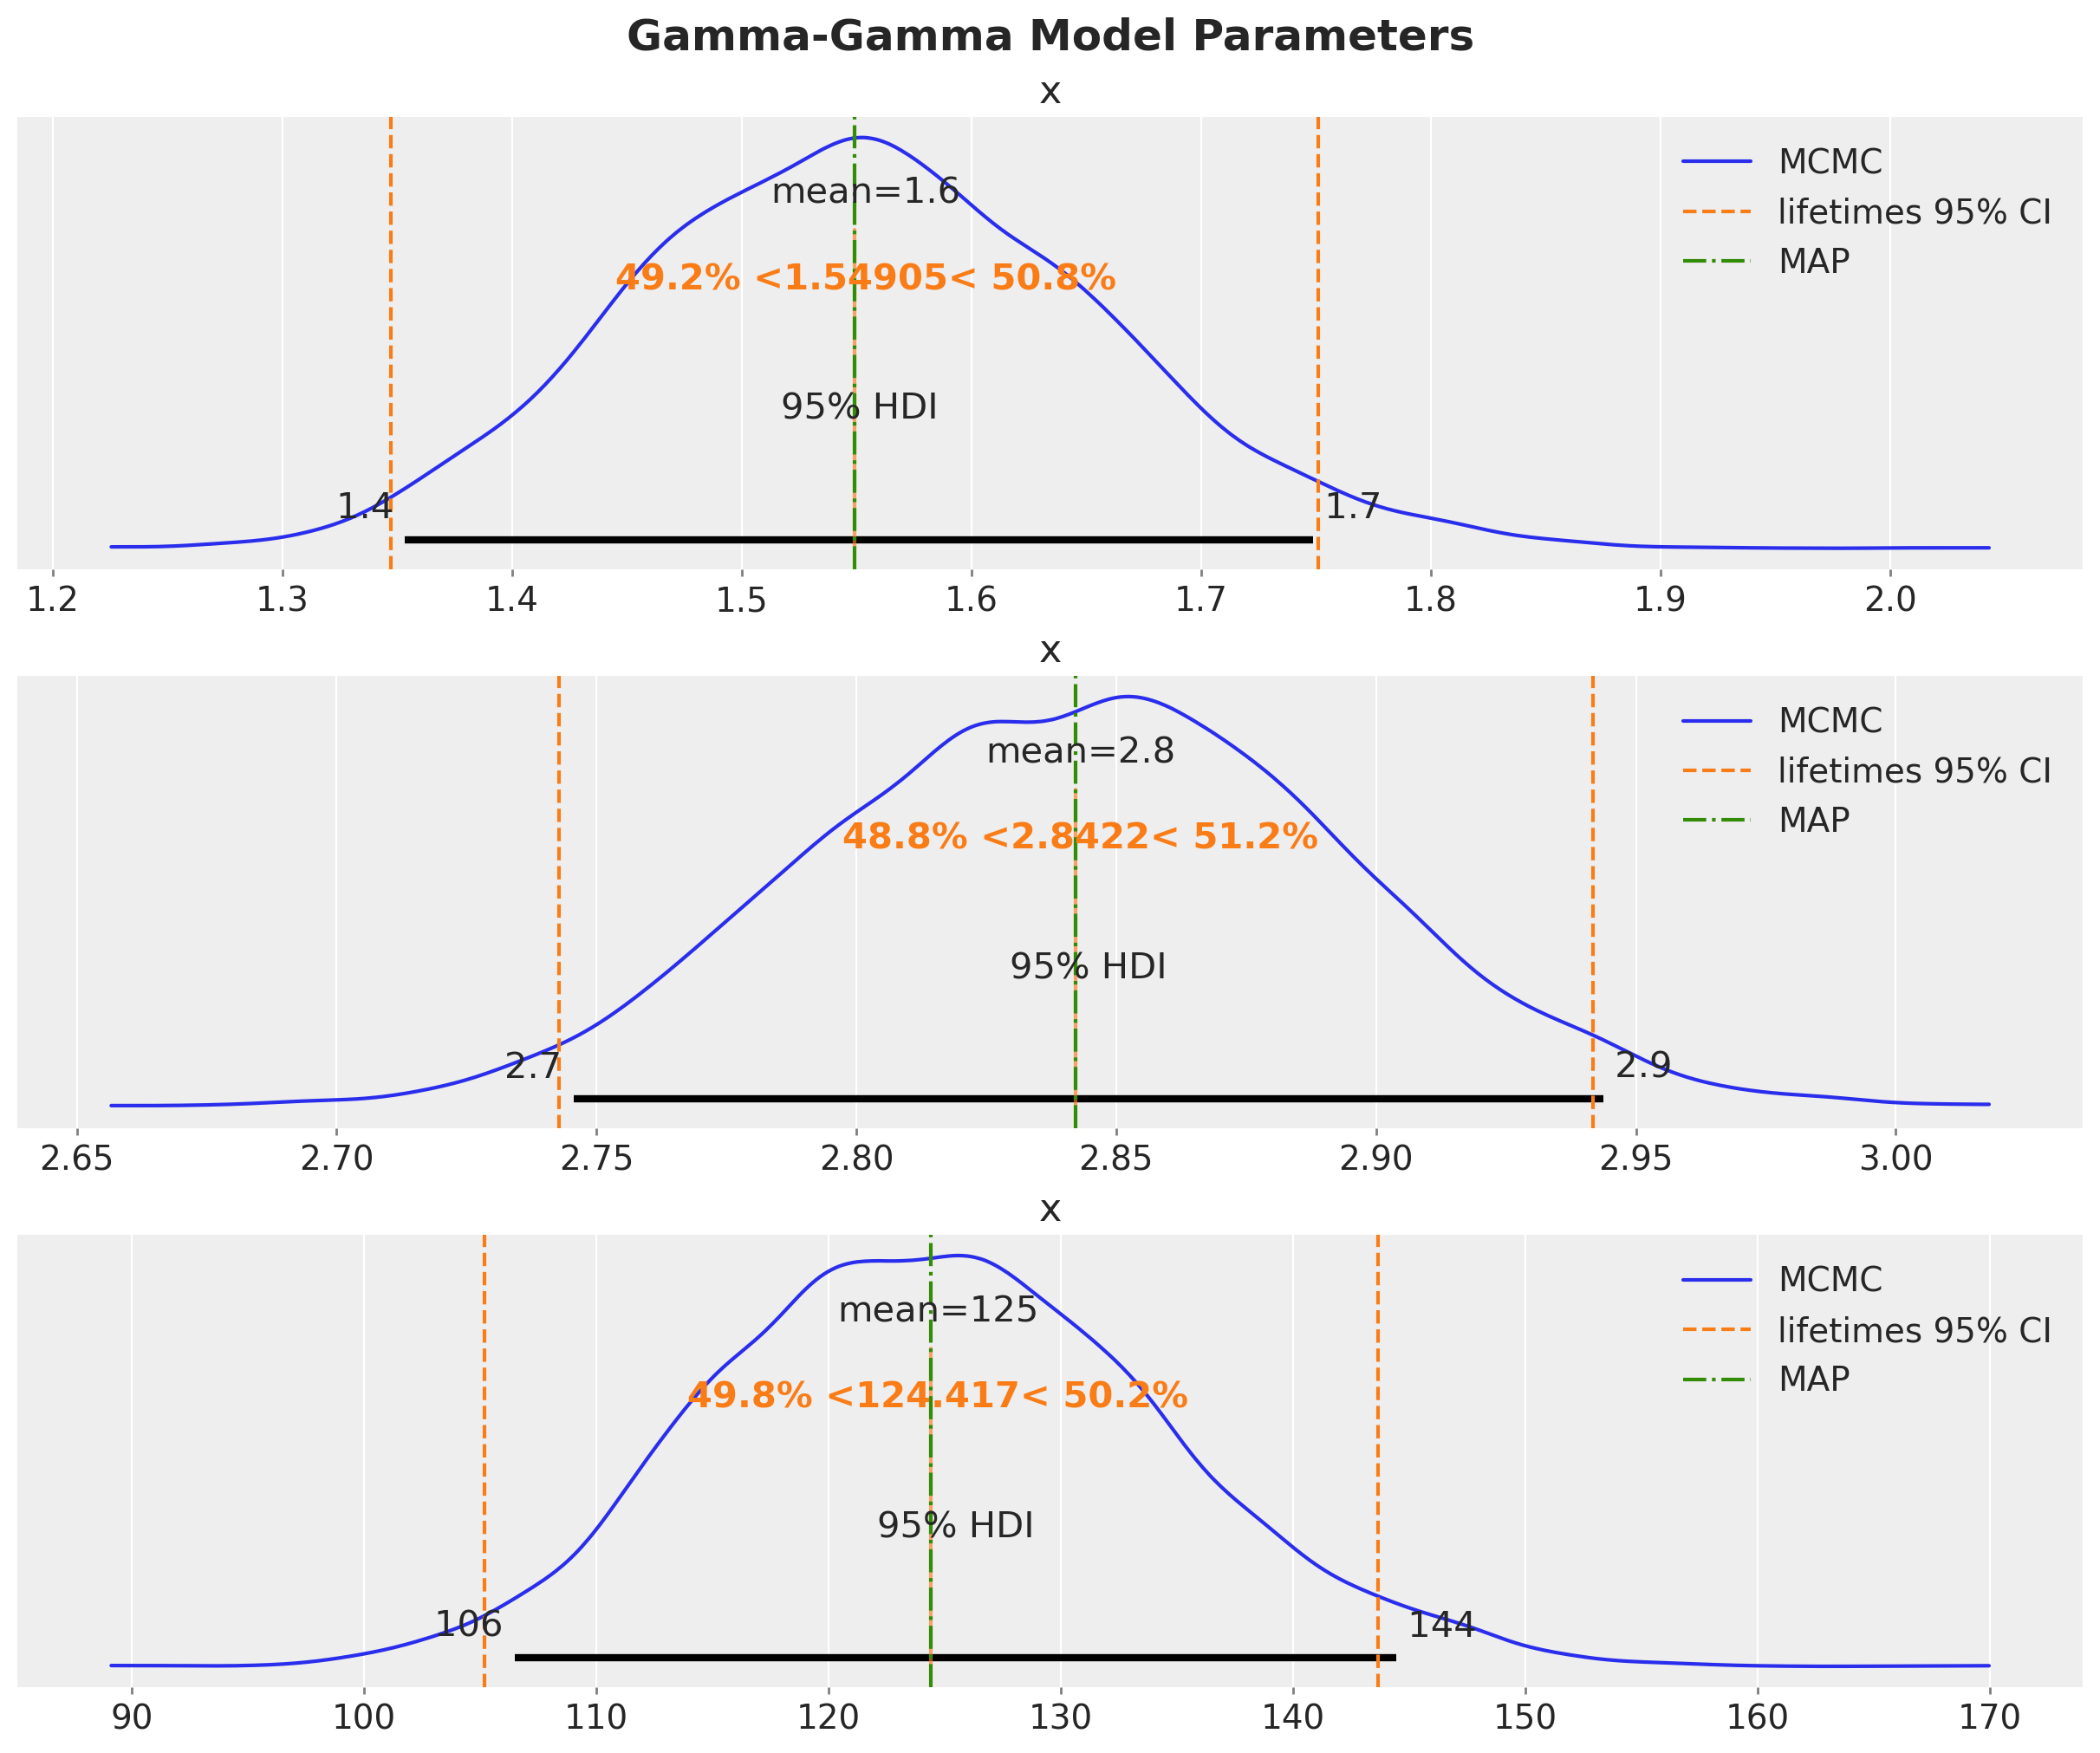

In [107]:
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(12, 10), sharex=False, sharey=False, layout="constrained"
)

for i, var_name in enumerate(["p", "q", "v"]):
    ax = axes[i]
    az.plot_posterior(
        idata_mcmc.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        hdi_prob=0.95,
        ref_val=ggf.summary["coef"][var_name],
        ax=ax,
        label="MCMC",
    )
    ax.axvline(
        x=ggf.summary["lower 95% bound"][var_name],
        color="C1",
        linestyle="--",
        label="lifetimes 95% CI",
    )
    ax.axvline(
        x=ggf.summary["upper 95% bound"][var_name],
        color="C1",
        linestyle="--",
    )
    ax.axvline(x=idata_map[var_name].item(), color="C2", linestyle="-.", label="MAP")
    ax.legend(loc="upper right")

plt.gcf().suptitle("Gamma-Gamma Model Parameters", fontsize=18, fontweight="bold");

In [109]:
expected_spend = model.expected_customer_spend(data=data_bg)

In [110]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[10016],95.458,0.463,94.573,96.314
x[10017],59.294,0.071,59.157,59.426
x[10048],47.583,0.853,46.019,49.228
x[10092],56.421,0.086,56.255,56.579
x[10150],251.995,0.013,251.970,252.018
x[10252],134.525,0.002,134.521,134.528
x[10365],142.086,0.003,142.081,142.092
x[10395],41.847,0.632,40.658,43.033
x[10528],100.068,0.002,100.064,100.071
x[10530],162.178,0.010,162.159,162.198


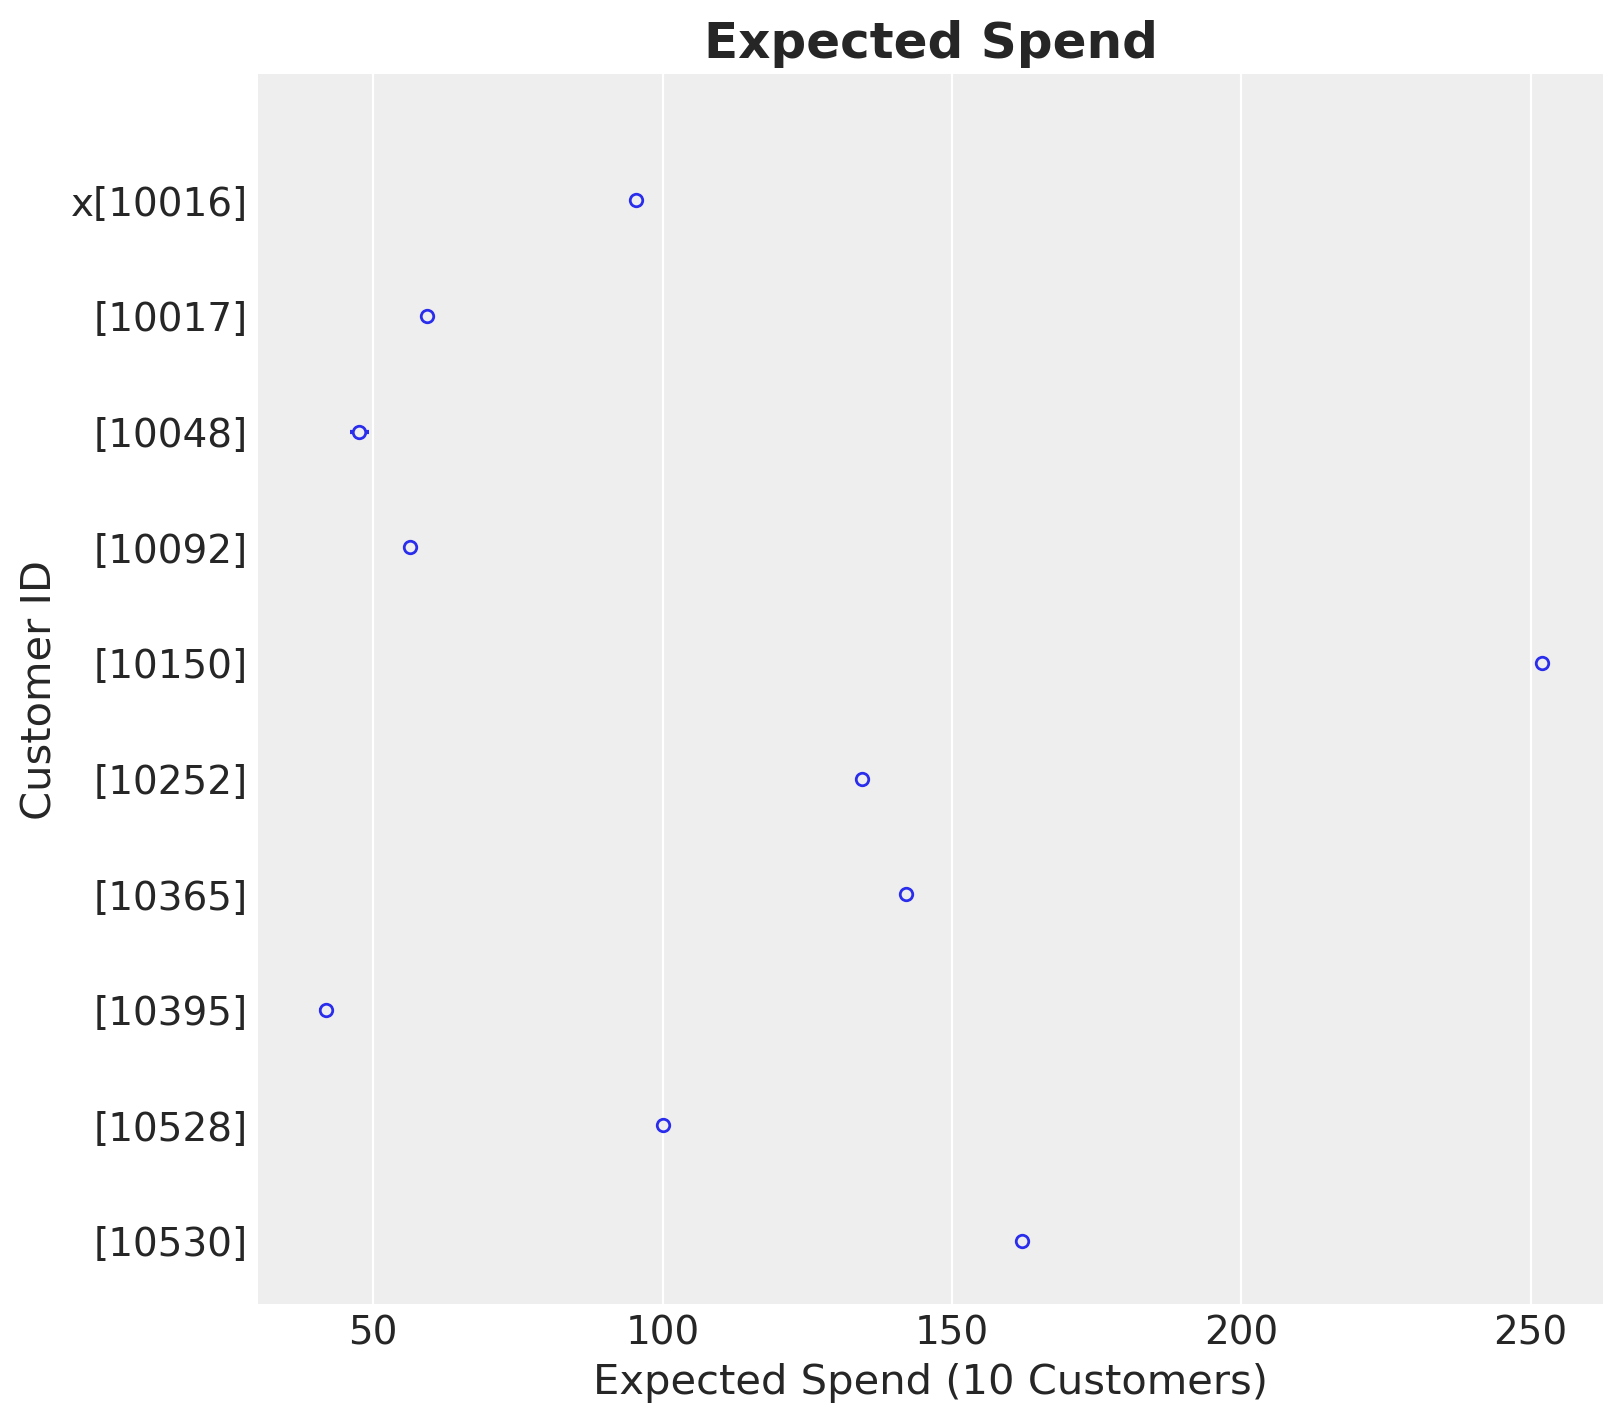

In [111]:
ax, *_ = az.plot_forest(
    data=expected_spend.isel(customer_id=(range(10))), combined=True, figsize=(8, 7)
)
ax.set(xlabel="Expected Spend (10 Customers)", ylabel="Customer ID")
ax.set_title("Expected Spend", fontsize=18, fontweight="bold");

In [112]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,112.647,0.14,112.381,112.901


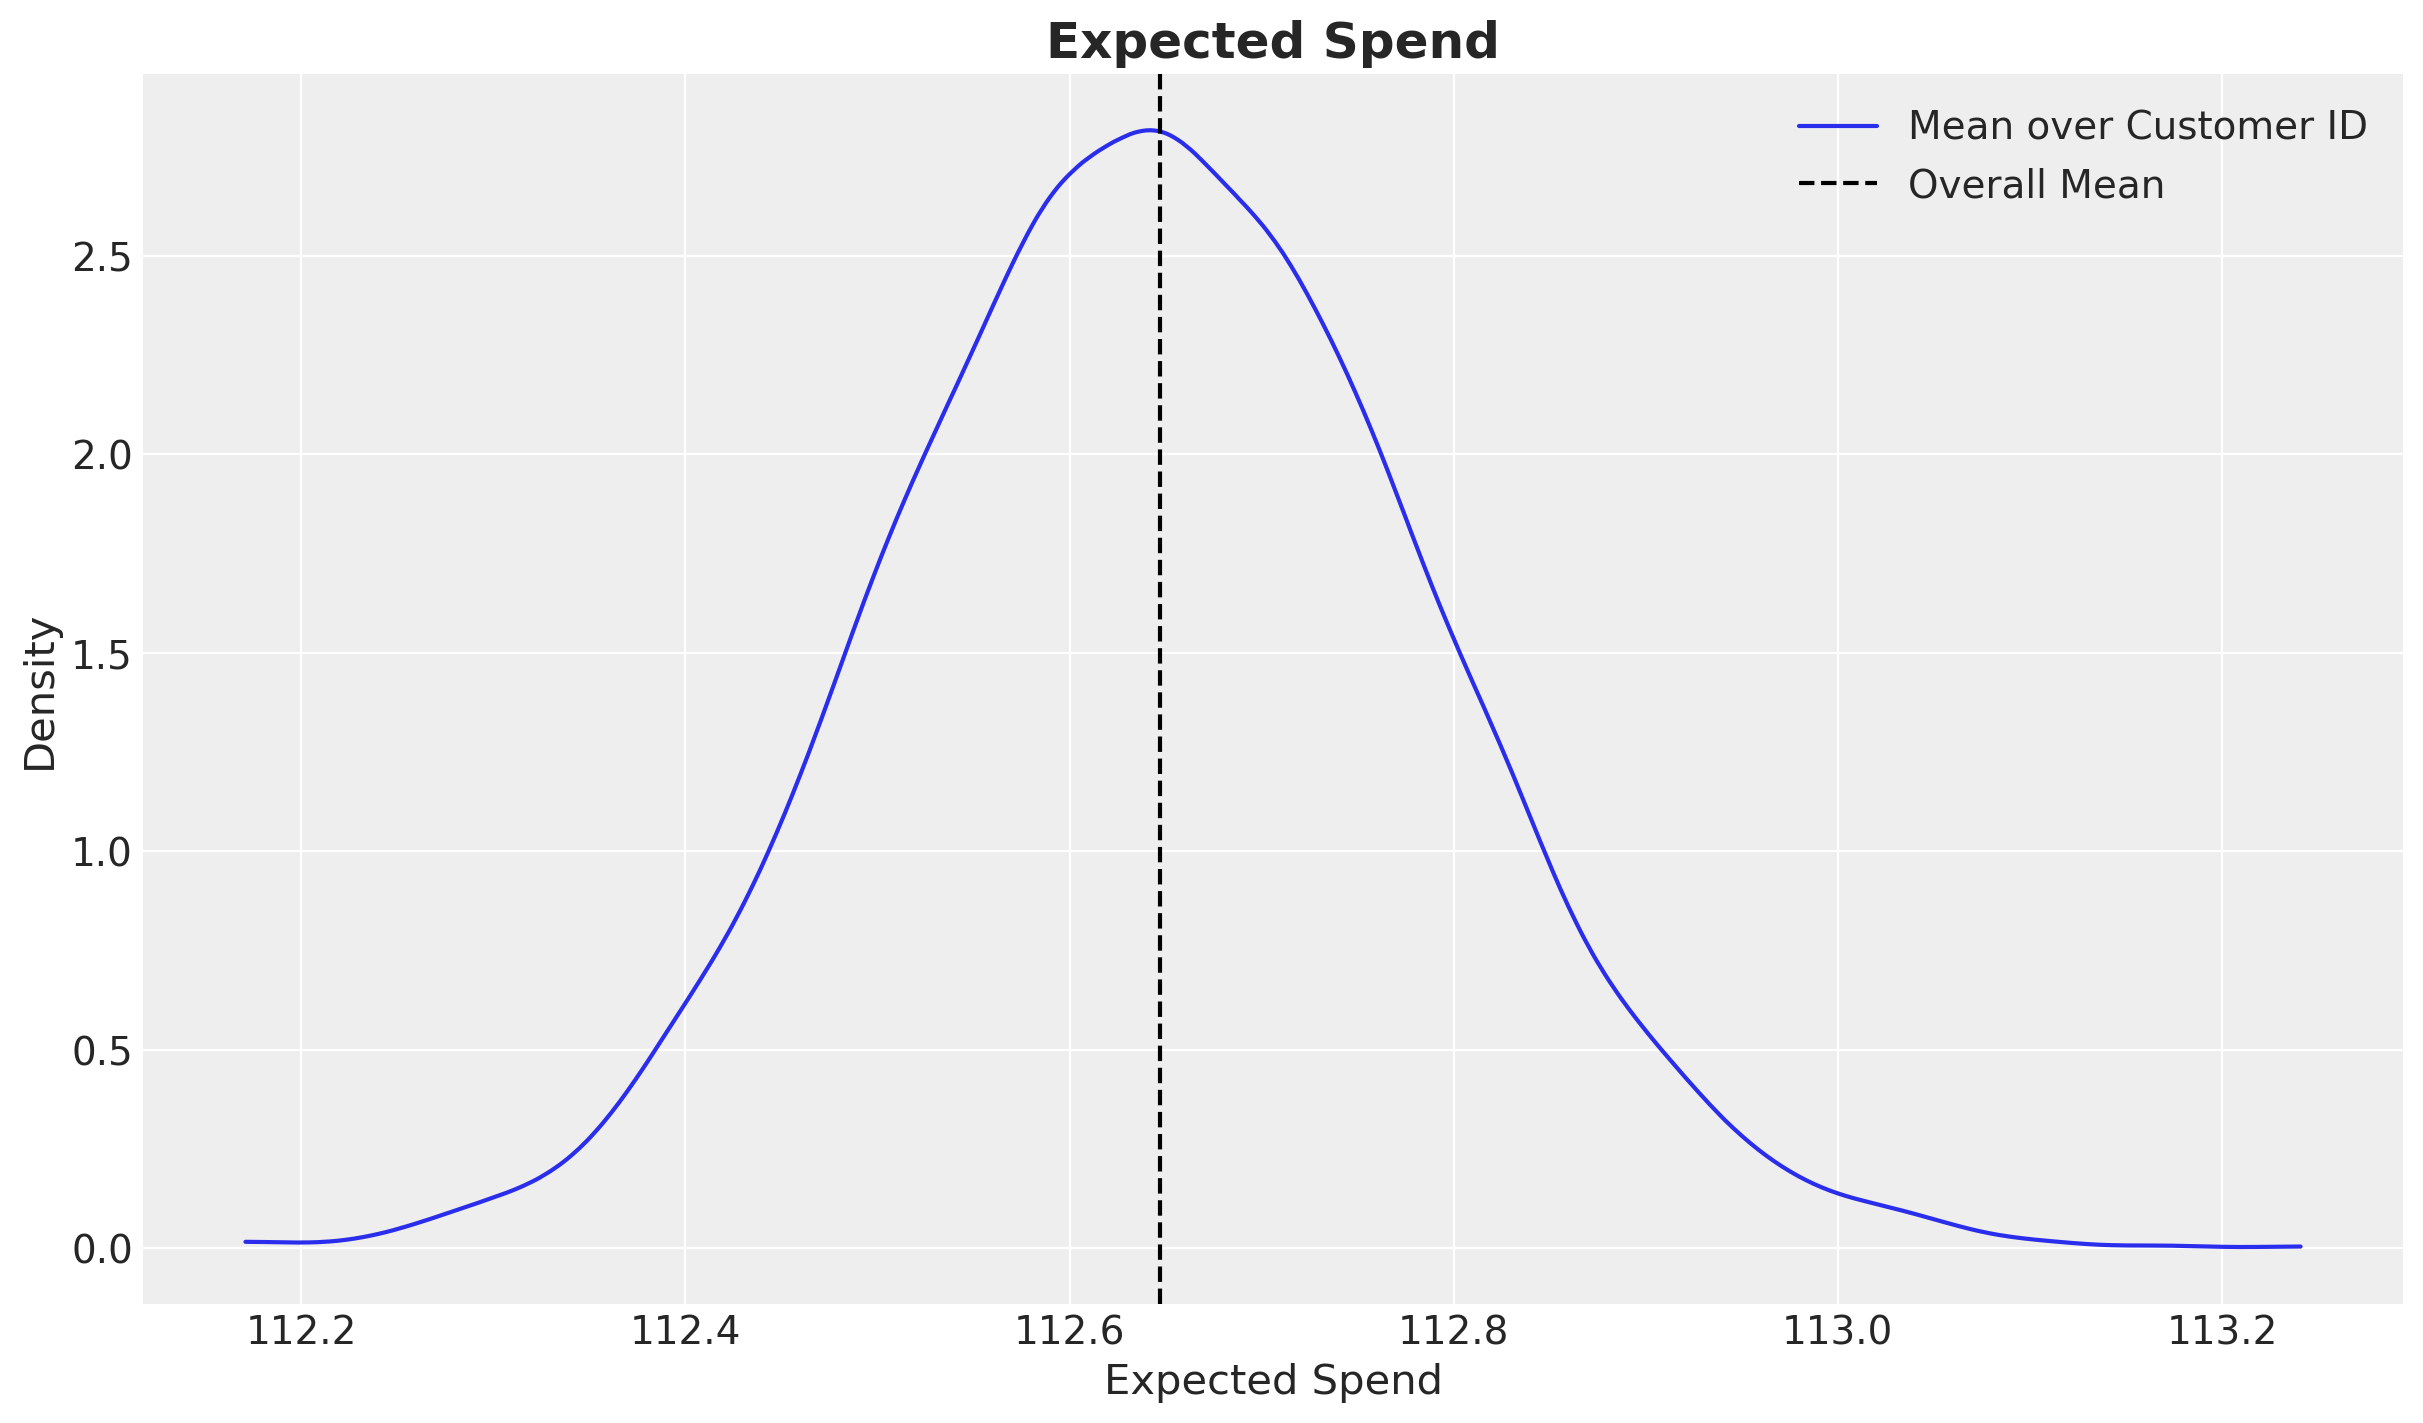

In [113]:
fig, ax = plt.subplots()
az.plot_dist(expected_spend.mean("customer_id"), label="Mean over Customer ID", ax=ax)
ax.axvline(x=expected_spend.mean(), color="black", ls="--", label="Overall Mean")
ax.legend(loc="upper right")
ax.set(xlabel="Expected Spend", ylabel="Density")
ax.set_title("Expected Spend", fontsize=18, fontweight="bold");

In [114]:
# datax = data_summary_rfm.query("customer_id = '4952'")
data_bg

,customer_id,frequency,recency,T,monetary_value
0,10016,2.0,372.0,1629.0,90.000000
1,10017,58.0,692.0,728.0,58.362069
2,10048,5.0,444.0,1019.0,34.000000
3,10092,51.0,1365.0,1387.0,55.294118
4,10150,1110.0,2129.0,2131.0,252.153153
...,...,...,...,...,...
9112,9886,1.0,6.0,1920.0,30.000000
9113,9911,43.0,112.0,117.0,76.395349
9114,9917,63.0,1376.0,1378.0,168.412698
9115,9930,140.0,1682.0,1942.0,63.928571
